In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import algopy
from algopy import UTPM, exp
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [2]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    #dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    #dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    return dataset

In [3]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False
        self.first_input_array = True

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035, latlon_proj = False):
        self.latlon_proj = latlon_proj
        ## Puts pandas phenological frame into driver xarray and aligns the two
        #self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        if self.first_input_array:
            self.obs_for_GDD = self.phen_data.where(self.phen_data['Eintrittsdatum'] >= np.datetime64('2001-01-01')).dropna()
            x_coords = self.obs_for_GDD['lon'].values
            y_coords = self.obs_for_GDD['lat'].values
            station_ids = np.int64(self.obs_for_GDD['Stations_id'].values)
            x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
            #Makes an array to put into GDD model
            print('project to new coords')
            self.stations = stations
            if not(latlon_proj):
                x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
                self.x_driver_proj = x_epsg
                self.y__driver_proj = y_epsg
            else:
                self.x_driver_proj = x_unique
                self.y__driver_proj = y_unique
            print('interpolate driver to station locations')
            # Working in xarray (not pandas) after this point:
            #print('Latlonproj:', not(latlon_proj))
            self.GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
            self.first_input_array = False
        else: 
            new_GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            new_GDD_driver_data = new_GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                new_GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            new_GDD_driver_data = new_GDD_driver_data.set_xindex(['Stations_id'])
            self.GDD_driver_data = xr.concat([self.GDD_driver_data, new_GDD_driver_data], dim='time')
            self.GDD_driver_data = self.GDD_driver_data.sortby('time')

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        self.obs_for_GDD = self.obs_for_GDD.where(self.obs_for_GDD['Referenzjahr'] <= 2023)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.obs_for_GDD = dataset_fctns.add_SOS_to_df(self.obs_for_GDD)
        self.obs_for_GDD['WC SOS date'] = pd.to_datetime(self.obs_for_GDD['Referenzjahr'], format='%Y') + pd.to_timedelta(self.obs_for_GDD['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.obs_for_GDD[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.obs_for_GDD['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.obs_for_GDD['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False, count_from_SOS = True):
        if count_from_SOS:
            self.phen_data = dataset_fctns.add_SOS_to_df(self.phen_data)
            self.phen_data['WC SOS date'] = pd.to_datetime(self.phen_data['Referenzjahr'], format='%Y') + pd.to_timedelta(self.phen_data['SOS'], 'D')
            self.ds_observed = self.phen_data[['Stations_id', 'Referenzjahr', 'lat', 'lon', 'WC SOS date']].drop_duplicates()
            for phase in self.phase_list:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == phase]
                just_phase= just_phase.assign(**{f'observed time to {phase}': just_phase['Eintrittsdatum'] - just_phase['WC SOS date']})
                self.ds_observed = self.ds_observed.merge(just_phase[[f'observed time to {phase}', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id'])
        else:
            observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
            self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
            for phase in self.phase_list[1:]:
                self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
            self.ds_observed = self.ds_observed.reset_index()
            self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
            self.ds_observed = self.ds_observed.merge(self.obs_for_GDD[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] 
        if not(self.latlon_proj):
            time_station['SOS'] += pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML[driver_variable].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_26712\182001988.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [4]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array(latlon_proj=True)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.where(Maize_set.GDD_driver_data['time'] >= np.datetime64('2012-01-01'), drop = True)
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
Maize_set.make_input_array(latlon_proj=True)
Maize_set.phase_list = ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()

Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [63]:
average_flowerings = []
average_ripeness = []
std_flowerings = []
std_ripeness = []
step = 2
for year in range(1991, 2023, step):
    obs_in_year = Maize_set.ds_observed.loc[np.logical_and(Maize_set.ds_observed['Referenzjahr'] >= year, Maize_set.ds_observed['Referenzjahr'] <= year + step - 1)]
    #obs_in_year.loc[:, 'observed time to beginning of flowering'] = obs_in_year['observed time to beginning of flowering'].dt.days
    #obs_in_year.loc[:, 'observed time to yellow ripeness'] = obs_in_year['observed time to yellow ripeness'].dt.days
    average_flowerings.append(np.mean(obs_in_year['observed time to beginning of flowering'].dt.days.dropna().values))
    std_flowerings.append(np.std(obs_in_year['observed time to beginning of flowering'].dt.days.dropna().values))
    average_ripeness.append(np.mean(obs_in_year['observed time to yellow ripeness'].dt.days.dropna().values))
    std_ripeness.append(np.std(obs_in_year['observed time to yellow ripeness'].dt.days.dropna().values))

In [64]:
obs_in_year['observed time to yellow ripeness'].dt.days#.dropna()

0        145.0
2        153.0
4        146.0
6          NaN
8        149.0
         ...  
86160    155.0
86265    168.0
86294      NaN
86348      NaN
87077      NaN
Name: observed time to yellow ripeness, Length: 1320, dtype: float64

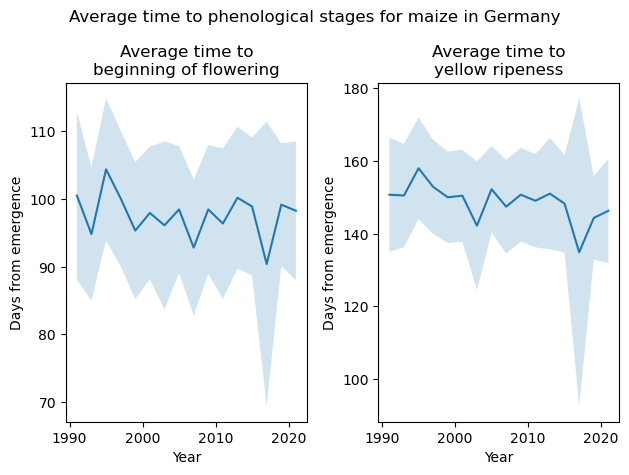

In [69]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.arange(1991, 2023, step), average_flowerings)
ax[0].fill_between(np.arange(1991, 2023, step), np.array(average_flowerings) - np.array(std_flowerings), np.array(average_flowerings) + np.array(std_flowerings), alpha=0.2)
ax[1].plot(np.arange(1991, 2023, step), average_ripeness)
ax[1].fill_between(np.arange(1991, 2023, step), np.array(average_ripeness) - np.array(std_ripeness), np.array(average_ripeness) + np.array(std_ripeness), alpha=0.2)
fig.suptitle('Average time to phenological stages for maize in Germany')
ax[0].set_title('Average time to\nbeginning of flowering')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Days from emergence')
ax[1].set_title('Average time to\nyellow ripeness')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Days from emergence')
fig.tight_layout()

In [5]:
def put_temp_values_in_frame(driver_array, ds_observed, driver_variable, latlon_proj = True, phase_list = ['yellow ripeness'], SOS_offset = 0, station_locations = False):
    
    observations_to_use = ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(ds_observed['Referenzjahr'] > 2000).dropna().drop_duplicates()
    observations_to_use['WC SOS date'] += np.timedelta64(SOS_offset, 'D')
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        driver_array = driver_array.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(300):
        # Pull values for temperature out of data frame
        driver_values = driver_array.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
        driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'temperature at day {day}'})
        observations_to_use = observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
        time_station['time'] += np.timedelta64(1, 'D')
    ds = observations_to_use.merge(ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])
    ds = ds.dropna(subset = ['temperature at day 0'] + [f'observed time to {phase}' for phase in phase_list]).drop_duplicates()#
    ds[[f'observed time to {phase}' for phase in phase_list]] = ds[[f'observed time to {phase}' for phase in phase_list]] + np.timedelta64(-SOS_offset, 'D')
    if type(station_locations) != bool:
        ds = get_station_locations(ds, station_locations)
    return ds

In [6]:
def put_ERA5_in_array(ds):
    ERA5_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc').sel(time=slice('2000-01-01', '2024-12-31'))
    ERA5_data = ERA5_data.rename({'latitude': 'lat', 'longitude': 'lon'})
    ERA5_clim = ERA5_data.mean(dim='time')
    lats_array = xr.DataArray(ds['lat'], dims="z")
    lons_array = xr.DataArray(ds['lon'], dims="z")
    ds['ERA5 clim'] = ERA5_clim.t2m.interp({'lat':lats_array, 'lon':lons_array}).values
    return ds

In [7]:
ds1 = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', phase_list = ['yellow ripeness'],
                               SOS_offset=0, station_locations=Maize_set.station_data)
#ds1 = ds1.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#
ds1 = ds1.where(ds1['observed time to yellow ripeness'].dt.days > 50).dropna()
ds1 = put_ERA5_in_array(ds1)
ds2 = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', phase_list = ['yellow ripeness'],
                               SOS_offset=12, station_locations=Maize_set.station_data)
#ds2['WC SOS date'] = ds2['WC SOS date']# +np.timedelta64(12, 'D')
ds2 = ds2.where(ds2['observed time to yellow ripeness'].dt.days > 50).dropna()
ds2 = put_ERA5_in_array(ds2)
ds = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', phase_list = ['beginning of flowering'],
                              SOS_offset=12, station_locations=Maize_set.station_data)
ds = ds.where(ds['observed time to beginning of flowering'].dt.days > 30).dropna()
ds = put_ERA5_in_array(ds)
print(ds['observed time to beginning of flowering'].dt.days.std(), 
      ds1['observed time to yellow ripeness'].dt.days.std(), 
      ds2['observed time to yellow ripeness'].dt.days.std())

Couldn't reset index for station
Couldn't reset index for station
Couldn't reset index for station
10.45465424026186 14.38538583116649 14.38538583116649


In [8]:
warm_threshold = 10
ds1_warm = ds1.loc[ds1['ERA5 clim'] > warm_threshold]
ds2_warm = ds2.loc[ds2['ERA5 clim'] > warm_threshold]
ds_warm = ds.loc[ds['ERA5 clim'] > warm_threshold]
ds1_cold = ds1.loc[ds1['ERA5 clim'] <= warm_threshold]
ds2_cold = ds2.loc[ds2['ERA5 clim'] <= warm_threshold]
ds_cold = ds.loc[ds['ERA5 clim'] <= warm_threshold]

In [135]:
print(ds1_warm['observed time to yellow ripeness'].dt.days.std(), ds2_warm['observed time to yellow ripeness'].dt.days.std(), ds_warm['observed time to beginning of flowering'].dt.days.std())

14.344866753121218 14.344866753121218 10.246885166016233


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3368\1892759173.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=ds1, x="observed yellow ripeness time", bins =50, ax=ax, palette = 'colorblind')


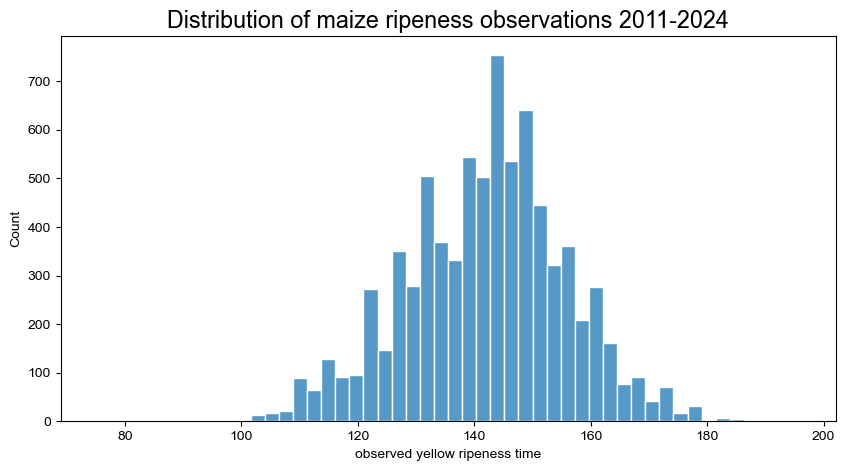

In [7]:
fig, ax = plt.subplots(figsize = (10, 5))
ds1['observed yellow ripeness time'] = ds1['observed time to yellow ripeness'].dt.days
sns.set(font_scale=1.4)
sns.histplot(data=ds1, x="observed yellow ripeness time", bins =50, ax=ax, palette = 'colorblind')
ax.set(ylabel='Count', title='Distribution of maize ripeness observations 2011-2024')
fig.savefig('plots/ripeness_obs_distribution.png', bbox_inches='tight')
#ax.tick_params(axis='both', which='major', labelsize=font_size)#axis='x', 
#ax.tick_params(axis='y', labelsize=10)

In [9]:
def run_GDD_and_get_RMSE(x, ds, driver_variable, latlon_proj = True, 
                         response_type = 'Trapezoid', phase_list = ['beginning of flowering'], 
                         new_unfinished_penalisation=False,
                         growing_period_length = 300, thresholds = [100]):
    if response_type == 'Trapezoid':
        def response(meantemp):
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(growing_period_length):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    unfinished_penalty=0
    if new_unfinished_penalisation:
        unfinished_penalty = max((comparison_array[f'modelled time to {phase_list[0]}'] >growing_period_length - 3).sum() - 0.03*comparison_array.shape[0], 0)
        comparison_array = comparison_array.where(comparison_array[f'modelled time to {phase_list[0]}'] < growing_period_length).dropna()
    def RMSE(residuals):
        if len(residuals) == 0:
            return 0
        else:
            return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    return RMSE(residuals) + unfinished_penalty#, comparison_array
    

In [10]:
def Trapezoid_Temp_derivs(T, T_min, T_opt1, T_opt2, T_max):
    pre_opt = ((T>=T_min)*(T<=T_opt1))*np.array([(T - T_min)/(T_opt1 - T_min),
                                               (T - T_opt1)/((T_opt1 - T_min)**2),
                                               (T_min - T)/((T_opt1 - T_min)**2),
                                               np.zeros(T.shape),
                                               np.zeros(T.shape)])
    opt = ((T>=T_opt1)*(T<=T_opt2))*np.array([np.ones(T.shape),
                                            np.zeros(T.shape),
                                            np.zeros(T.shape),
                                            np.zeros(T.shape),
                                            np.zeros(T.shape)])
    post_opt = ((T>=T_opt2)*(T<=T_max))*np.array([(T_max - T)/(T_max - T_opt2) ,
                                               np.zeros(T.shape),
                                               np.zeros(T.shape),
                                               (T_max - T)/((T_opt2 - T_max)**2),
                                               (T - T_opt2)/((T_opt2 - T_max)**2),])
    return pre_opt + opt + post_opt

In [11]:
def Wang_Temp_Derivs(T, T_min, T_opt, T_max):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    h = (np.sign(T - T_min)*(T - T_min)/(T_opt - T_min))**alpha
    #h_log = np.log(2)*(np.log((T - T_min)/(T_opt - T_min))/np.log((T_max - T_min)/(T_opt - T_min)))
    h_log = np.log(h)
    Dh_logDT = np.array([(1/(T_opt - T_min)) - (1/(T - T_min)) + (((1/(T_max - T_min)) - (1/(T_opt - T_min)))*h_log)/np.log(2),
                         -(1/(T_opt - T_min)) + (1/(T_opt - T_min))*h_log/np.log(2),
                         -(1/(T_max - T_min))*h_log/np.log(2)])*np.log(2)/np.log((T_max - T_min)/(T_opt - T_min))
    DhDT = h*Dh_logDT
    DfDT = (2*DhDT - 2*h*DhDT)*(T >= T_min)*(T<= T_max)
    DfDT = np.nan_to_num(DfDT)
    return [DfDT[0], DfDT[1], DfDT[2]]

In [10]:
T = np.array([24, 24, 24])
T_min = np.array([10, 10, 10])
T_opt = np.array([28, 28, 28])
T_max = np.array([36, 36, 36])
D = Wang_Temp_Derivs(T, T_min, T_opt, T_max)
D

[array([-0.00371164, -0.00371164, -0.00371164]),
 array([-0.08283785, -0.08283785, -0.08283785]),
 array([0.02328237, 0.02328237, 0.02328237])]

In [11]:
Wang_num_deriv = np.array([(modelling_fctns.Wang_Engel_Temp_response(24, 10.01, 28, 36) - modelling_fctns.Wang_Engel_Temp_response(24, 9.99, 28, 36))/0.02,
                  (modelling_fctns.Wang_Engel_Temp_response(24, 10, 28.001, 36) - modelling_fctns.Wang_Engel_Temp_response(24, 10, 27.999, 36))/0.002,
                  (modelling_fctns.Wang_Engel_Temp_response(24, 10, 28, 36.01) - modelling_fctns.Wang_Engel_Temp_response(24, 10, 28, 35.99))/0.02])
Wang_num_deriv

array([-0.00371164, -0.08283785,  0.02328241])

In [12]:
def run_GDD_and_get_RMSE_derivs(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                                phase_list = ['beginning of flowering'],growing_period_length = 300,
                                thresholds = [100]):
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    accumulated_deriv_time_series = [[t_dev.copy()] for count in range(len(x))]
    dev_time_series = [t_dev.copy()]
    list_of_responses = [] 
    #Run model
    for day in range(growing_period_length):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}'].values
        resp = response(driver_values)
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        if response_type == 'Trapezoid':
            response_deriv = x[0]*Trapezoid_Temp_derivs(driver_values, x[1], x[2], x[3], x[4])
            response_deriv[0, :] = response_deriv[0, :]/x[0]
        elif response_type == 'Wang':
            response_deriv_no_scale = Wang_Temp_Derivs(driver_values, x[1], x[2], x[3])
            response_deriv = [resp/x[0]] + [x[0]*deriv for deriv in response_deriv_no_scale]
        for x_index in range(len(x)):
            accumulated_deriv_time_series[x_index].append(accumulated_deriv_time_series[x_index][-1] + response_deriv[x_index])
        t_dev += resp#, t_dev)
        list_of_responses.append(resp)
        #print(len(accumulated_deriv_time_series[0][-1]))
        #print(accumulated_deriv_time_series[0][-1], t_dev/x[0])
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    resps_list = np.zeros(model_dev_time_series.shape[1])
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64)) - 1
        resps_list[obs_index] = list_of_responses[int(phase_dates_array[-1, obs_index]) - 1][obs_index].mean()
    resps_list += 0.1*x[0]*(resps_list == 0)
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names).astype('int64')
    for x_index in range(len(x)):
        accumulated_derivs = accumulated_deriv_time_series[x_index]
        accumulated_derivs.append(ds['Referenzjahr'].values)
        accumulated_derivs.append(ds['Stations_id'].values)
        #print(accumulated_derivs[300])
        for phase in phase_list:
            accumulated_derivs.append(np.array(accumulated_derivs).T[np.arange(len(ds)), phase_dates_array[f'modelled time to {phase}'].values])
        column_names = np.array(['Referenzjahr', 'Stations_id'] + [f'x{x_index} deriv for {phase}'])
        #print(np.array(accumulated_derivs[301]))
        if x_index == 0:
            #derivs_array1 = pd.DataFrame(np.array(accumulated_derivs[301:]).T, columns = column_names)
            derivs_array = pd.DataFrame(np.array(accumulated_derivs[(growing_period_length + 1):]).T, columns = column_names)
            #print(derivs_array.shape)
        else:
            derivs_array2 = pd.DataFrame(np.array(accumulated_derivs[(growing_period_length + 1):]).T, columns = column_names)
            derivs_array = derivs_array.merge(derivs_array2, how='left', on=['Referenzjahr', 'Stations_id'])
            #print(derivs_array.shape)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    comparison_array = comparison_array.merge(derivs_array, on=['Referenzjahr', 'Stations_id'])
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    error = RMSE(residuals)
    #print(len(residuals), len(comparison_array))
    #print(residuals)
    deriv_list = [
        -((comparison_array[f'modelled time to {only_phase}'] - comparison_array[f'observed time to {only_phase}'].dt.days)*
         comparison_array[f'x{xindex} deriv for {only_phase}']/resps_list).mean()/error for xindex in range(len(x))#x[0]
         #(comparison_array['modelled time to yellow ripeness']/(1 + comparison_array[f'x{xindex} deriv for yellow ripeness']) - comparison_array['modelled time to yellow ripeness'])).sum() for xindex in range(len(x))
    ]
    return deriv_list#, resps_list#, comparison_array#, comparison_array, derivs_array, accumulated_deriv_time_series#, resps_list#, comparison_array, phase_dates_array, derivs_array, derivs_array2, derivs_array1
    

In [73]:
def local_opt(x1s, ds, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], 
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True):
    if split:
        train, test = train_test_split(ds, test_size=0.5, random_state = 1)
    else:
        train = ds
        test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[constraints],
                                    options={'verbose': 3, 'initial_tr_radius': 1, 'gtol':1e-4, 'maxiter':maxiter},
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':50, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        print(x0, res.x, x0 - res.x)
        print('RMSE at opt on test set: ', run_GDD_and_get_RMSE(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds))
        print('R^2:', 1 - (run_GDD_and_get_RMSE(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds, growing_period_length=growing_period_length, new_unfinished_penalisation=modified_cost)**2/(test[f'observed time to {only_phase}'].dt.days.var())))
        final_mins.append(res.x)
    return final_mins, res

In [14]:
def plot_profiles_at_minimum(x_opt, ds, lb=[0.05, 4, 20, 20, 35], ub = [1, 12, 33, 33, 60], 
                             response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
                             growing_period_length = 300, new_unfinished_penalisation=False,
                             thresholds = [100]):
    x_min = x_opt.copy()
    fig, axs = plt.subplots(1, len(x_min), figsize = (15, 3))
    if response_type == 'Trapezoid':
        parameter_names = ['Scale', 'T_min', 'T_opt1', 'T_opt2', 'T_max']
    elif response_type == 'Wang':
        parameter_names = ['Scale', 'T_min', 'T_opt', 'T_max']
    for x_index in range(len(x_min)):
        parameter_name = parameter_names[x_index]
        print(f'Plotting {parameter_name}')
        if x_index == 0:
            x_i = np.arange(x_min[x_index] - 0.02, x_min[x_index] + 0.02, 0.005)#0.002)
        elif x_index > 2:
            x_i = np.arange(x_min[x_index] - 1/2, x_min[x_index] + 1/2, 0.1)#0.05)
        else:
            x_i = np.arange(x_min[x_index] - 1/2, x_min[x_index] + 1/2, 0.1)#0.05)
        RMSEs = np.zeros(x_i.shape)
        for i in range(x_i.shape[0]):
            #print(x_i[i])
            x_for_plotting = x_min.copy()
            x_for_plotting[x_index] = x_i[i]
            RMSEs[i] = run_GDD_and_get_RMSE(x_for_plotting, ds, 't2m', response_type=response_type, phase_list = phase_list,
                                            growing_period_length = growing_period_length, new_unfinished_penalisation=new_unfinished_penalisation,
                                            thresholds = thresholds)
        axs[x_index].plot(x_i, RMSEs, label = 'Cost as parameter changes')
        axs[x_index].axvline(lb[x_index], linestyle = '--', color = 'red', label = 'bounds of optimisation')
        axs[x_index].axvline(ub[x_index], linestyle = '--', color = 'red')
        #axs[x_index].axvline(x_min[x_index], color = 'green', label = 'Optimized value')
        axs[x_index].scatter(x_min[x_index], 
                             run_GDD_and_get_RMSE(x_min, ds, 't2m', response_type=response_type, phase_list = phase_list,
                                                  growing_period_length = growing_period_length, new_unfinished_penalisation=new_unfinished_penalisation,
                                                  thresholds = thresholds),
                            color = 'green', label = 'Optimized value')
        axs[x_index].set_xlim(x_i.min(), x_i.max())
        axs[x_index].set(xlabel = parameter_name)
        axs[x_index].set(ylabel = 'Cost')
        if x_index == 0:
            fig.legend()
    fig.suptitle('Profiles of RMSE for adapting parameters')

In [70]:
ds2_warm

,Stations_id,Referenzjahr,WC SOS date,temperature at day 0,temperature at day 1,temperature at day 2,temperature at day 3,temperature at day 4,temperature at day 5,temperature at day 6,...,temperature at day 294,temperature at day 295,temperature at day 296,temperature at day 297,temperature at day 298,temperature at day 299,observed time to yellow ripeness,lat,lon,ERA5 clim
4,7592.0,2022.0,2022-04-27,9.883457,9.943527,9.175364,9.814859,10.097809,11.693314,10.073165,...,6.679622,8.160091,6.163802,5.840069,4.476086,4.885972,134 days,53.4833,10.6333,10.366276
19,7665.0,2022.0,2022-04-27,9.355157,9.173754,8.241688,9.200557,9.786952,11.041364,9.499859,...,6.622880,8.293504,6.293787,5.841926,4.499135,5.132974,121 days,53.6333,9.8500,10.345750
20,7665.0,2023.0,2023-04-27,6.644498,8.476292,9.681987,7.708178,10.608143,8.340252,7.544161,...,4.101923,5.803060,8.606867,5.689500,4.418203,7.536544,129 days,53.6333,9.8500,10.345750
44,7786.0,2022.0,2022-04-27,9.272325,9.316334,8.260796,9.199857,9.588972,11.072532,9.792149,...,6.418757,7.961976,5.947614,5.482432,4.161102,4.775408,147 days,53.7333,10.2667,10.087043
45,7798.0,2022.0,2022-04-27,9.114794,9.332744,8.188020,9.213516,9.470461,10.861816,9.956441,...,6.383495,7.838968,5.952352,5.371015,4.125476,4.697455,138 days,53.8667,10.3333,10.010105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16779,19755.0,2011.0,2011-04-30,13.562875,10.389329,6.181947,6.807596,6.825064,7.752528,12.122334,...,-1.489987,-2.087123,-4.568889,-6.504321,-7.615842,-6.380185,160 days,51.2873,11.0183,10.056517
16780,19755.0,2012.0,2012-04-29,18.478368,16.760713,16.266181,16.853888,14.815302,13.876938,9.822490,...,3.863416,2.898166,-0.283139,1.195483,4.276737,5.594398,146 days,51.2873,11.0183,10.056517
16782,19755.0,2014.0,2014-04-30,14.326874,12.832933,7.675281,7.509201,6.603916,9.344061,12.348269,...,3.298813,4.526855,3.882183,6.395001,3.379317,2.053046,158 days,51.2873,11.0183,10.056517
16783,19755.0,2015.0,2015-04-30,9.322028,8.541603,9.154523,11.119687,15.815077,17.366592,13.774780,...,1.564098,0.645604,3.077730,3.578748,0.738777,0.908684,165 days,51.2873,11.0183,10.056517


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 95
[ 0.3  6.  29.5 42. ] [ 0.3  6.  29.5 42. ] [0. 0. 0. 0.]
RMSE at opt on test set:  0
R^2: nan
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max
Optimization terminated successfully.
         Current function value: 11.228719
         Iterations: 80
         Function evaluations: 177
[ 0.3  6.  29.5 42. ] [ 0.24106038  5.05662763 28.68988122 43.99775105] [ 0.05893962  0.94337237  0.81011878 -1.99775105]
RMSE at opt on test set:  11.228718752840571
R^2: 0.4726401977921263
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max
Optimization terminated successfully.
         Current function value: 11.677328
         Iterations: 87
         Function evaluations: 188
[ 0.3  6.  29.5 42. ] [ 0.24451807  5.97027328 28.02394353 43.95815795] [ 0.05548193  0.02972672  1.47605647 -1.95815795]
RMSE at opt on test set:  11.677328461596
R^2: 0.12891

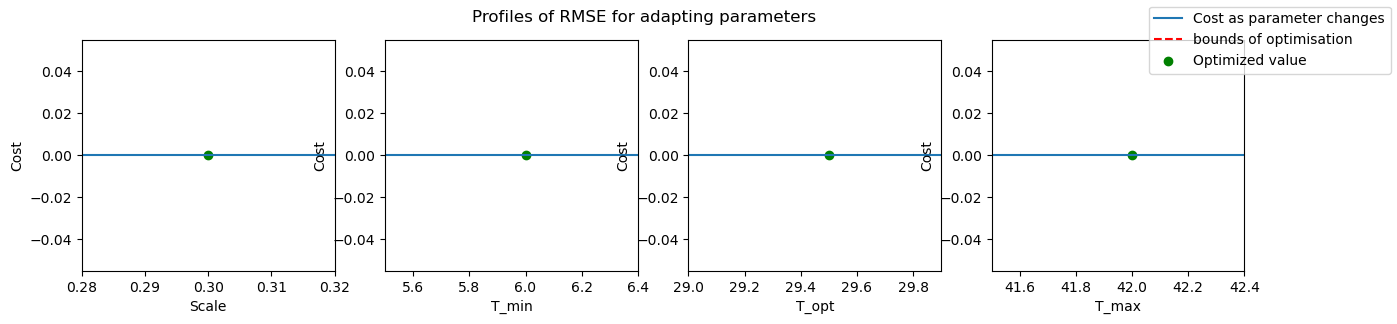

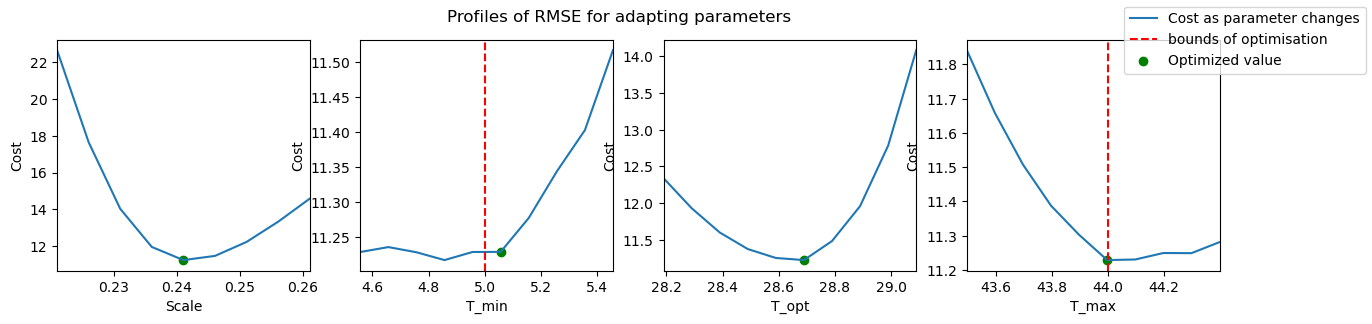

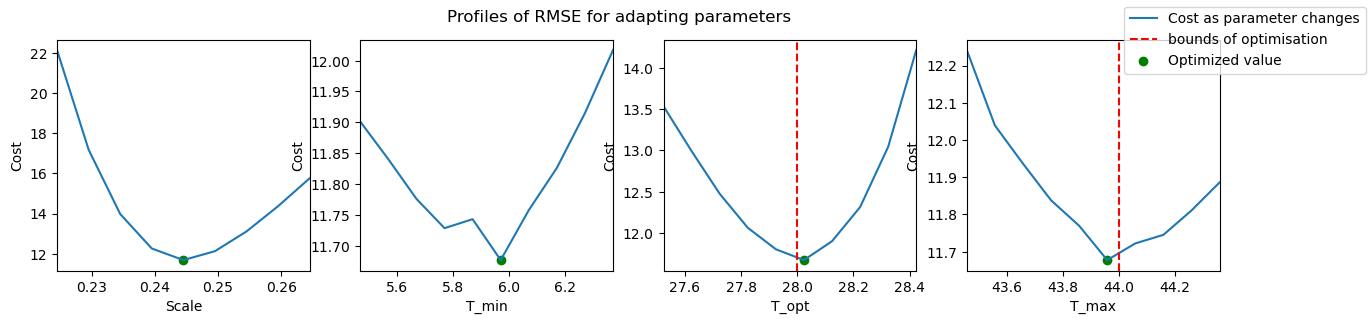

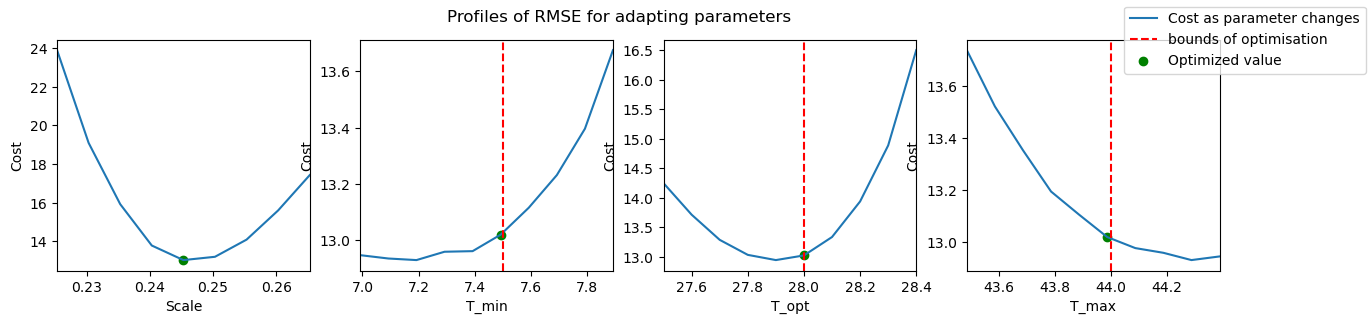

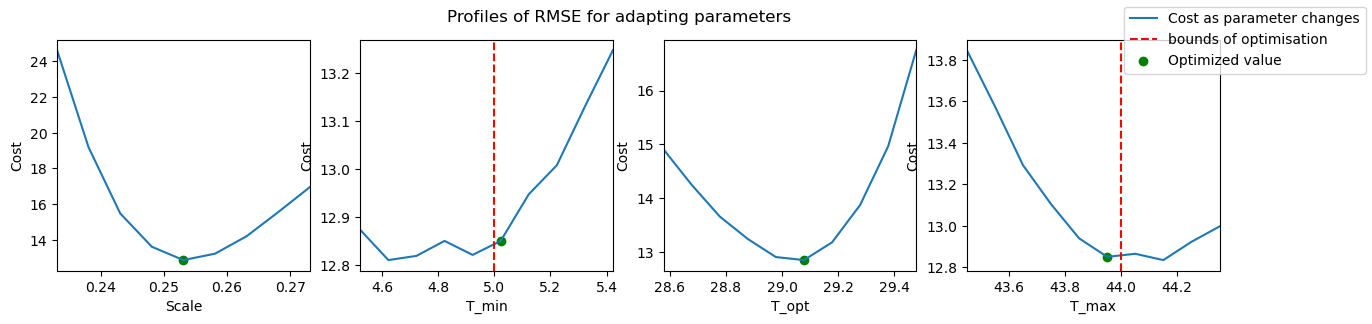

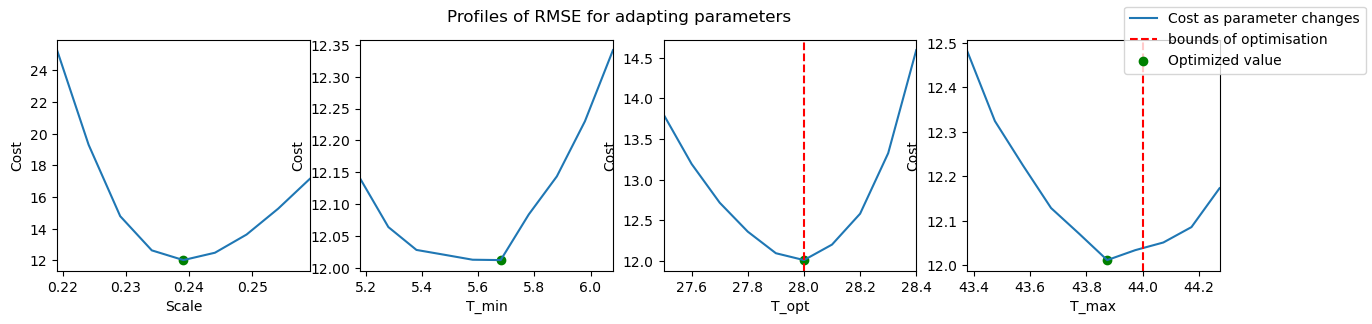

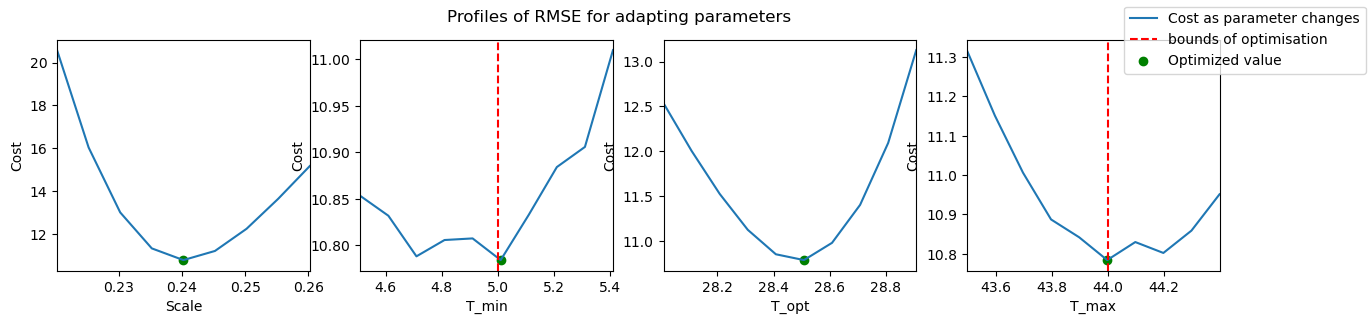

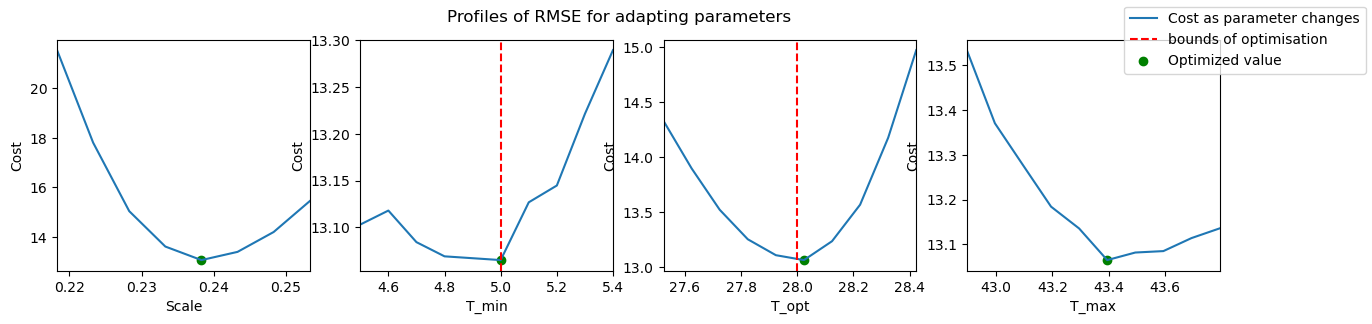

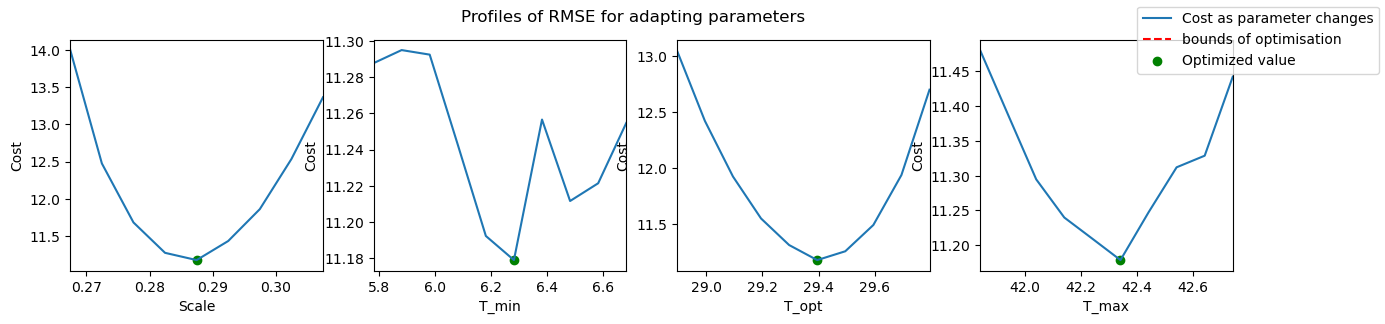

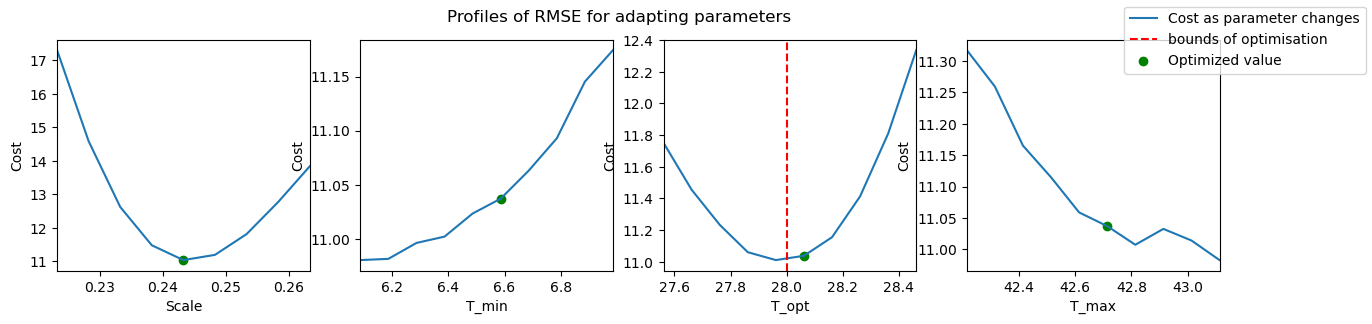

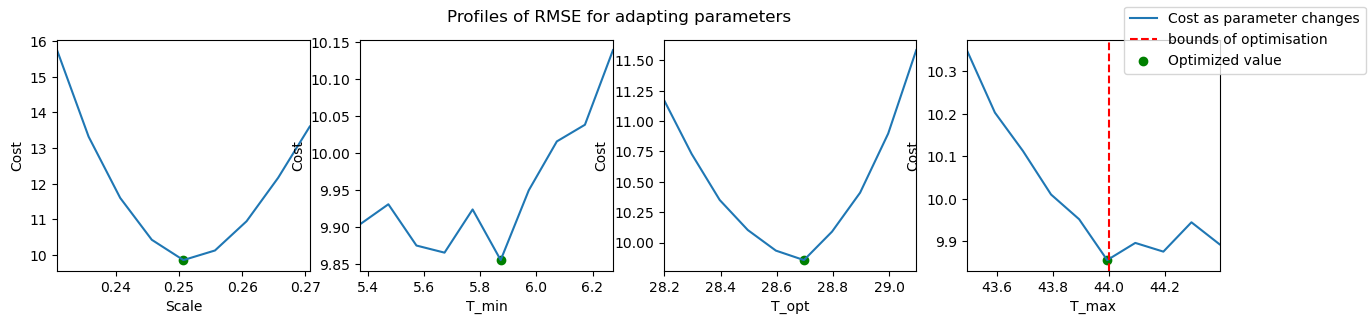

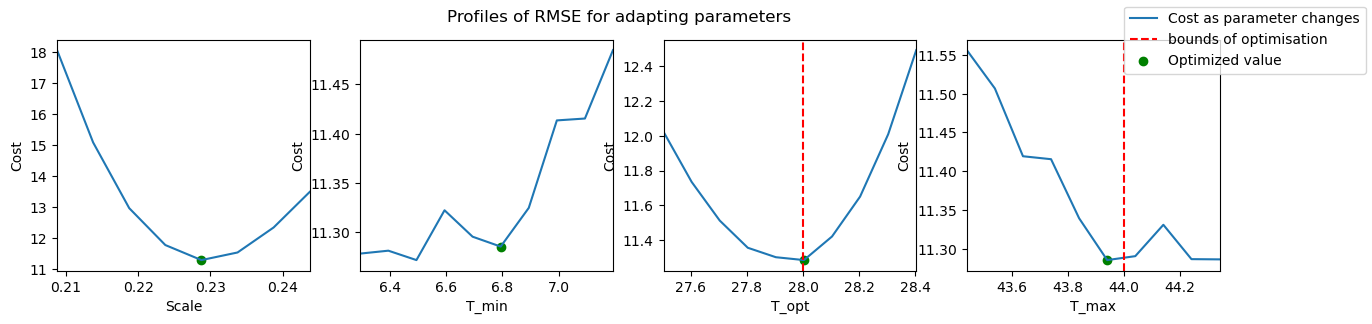

In [74]:
start_year = 2000
end_year = 2023
step = 2
response_type = 'Wang'
phase_list = ['yellow ripeness']
method = 'trust-constr', 
modified_cost = False, 
thresholds = [100], 
growing_period_length = 185,
maxiter = 50
x1s = [np.array([0.3, 6, 29.5, 42])]
param_list = []
for year in range(start_year, end_year, step):
    ds2_warm_period = ds2_warm.loc[(ds2_warm['Referenzjahr'] >= year)*(ds2_warm['Referenzjahr'] < year + step)]
    fms, res = local_opt(x1s, ds2_warm_period, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300, split = False)
    plot_profiles_at_minimum(fms[0], ds2_warm_period, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])
    param_list.append(fms[0])
    #print(ds2_warm_period)


In [15]:
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm_all_ripeness, res = local_opt(x1s, ds2, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

Optimization terminated successfully.
         Current function value: 14.168034
         Iterations: 130
         Function evaluations: 237
[ 0.3  6.  29.5 42. ] [ 0.24281304  5.00383729 28.15685861 43.96110362] [ 0.05718696  0.99616271  1.34314139 -1.96110362]
RMSE at opt on test set:  19.941897092174766
R^2: -0.029379434800168136


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


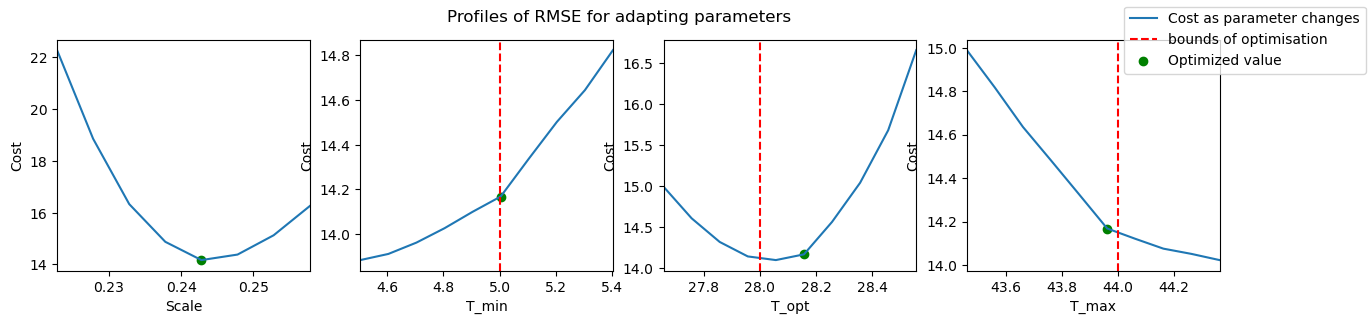

In [21]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm_all_ripeness[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [16]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.3, 6, 29.5, 42])]
fms, res = local_opt(x1s, ds2_cold, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20])


Optimization terminated successfully.
         Current function value: 13.376611
         Iterations: 107
         Function evaluations: 206
[ 0.3  6.  29.5 42. ] [ 0.25222093  5.01214034 28.02067488 43.695618  ] [ 0.04777907  0.98785966  1.47932512 -1.695618  ]
RMSE at opt on test set:  17.82466439988874
R^2: 0.12521048556632275


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


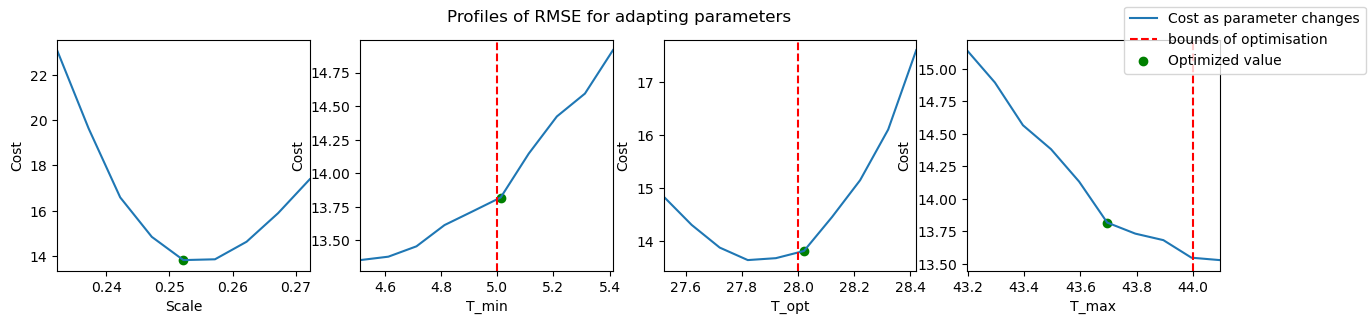

In [17]:
train, test = train_test_split(ds2_cold, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fms[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [18]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm2s, res = local_opt(x1s, ds2_warm, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +1.5930e+01 | 1.00e+00 | 1.62e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +1.3414e+02 | 2.00e+00 | 2.11e+07 | 2.77e-02 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   5   | +6.9101e+01 | 1.15e+01 | 2.69e+01 | 0.00e+00 | 4.56e+05 |  1.00e-01   |   2   |
|   4   |   4   |   9   | +6.9101e+01 | 1.15e+01 | 1.77e+02 | 0.00e+00 | 4.56e+05 |  1.00e-01   |   2   |
|   5   |   5   |  13   | +6.9101e+01 | 1.15e+01 | 3.55e+02 | 0.00e+00 | 4.56e+05 |  1.00e-01   |   1   |
|   6   |   6   |  17   | +6.9101e+01 | 1.15e+01 | 4.56e+02 | 0.00e+00 | 4.56e+05 |  1.00e-01   |   1   |
|   7   |   7   |  21   | +6.8890e+01 | 1.15e+01 | 1.73e+03 | 0.00e+00 | 4.56e+05 |  1.00e-01   |   1   |
|   8   |   8   |  25   | +1.2244e+01 | 1.15e+

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  74   |  121  |  147  | +1.2058e+01 | 1.00e-01 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   4   |
|  75   |  123  |  148  | +1.2058e+01 | 1.00e-02 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   4   |
|  76   |  124  |  149  | +1.2058e+01 | 4.65e-03 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  77   |  126  |  150  | +1.2058e+01 | 1.13e-03 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   4   |
|  78   |  128  |  151  | +1.2058e+01 | 5.29e-04 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  79   |  130  |  152  | +1.2058e+01 | 2.64e-04 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  80   |  132  |  153  | +1.2058e+01 | 9.37e-05 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  81   |  134  |  154  | +1.2058e+01 | 3.21e-05 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  82   |  136  |  155  | +1.2058e+01 | 5.13e-06 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  83   |  138  |  156  | +1.2058e+01 | 5.13e-07 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  84   |  140  |  157  | +1.2058e+01 | 5.13e-08 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  85   |  142  |  158  | +1.2058e+01 | 5.13e-09 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  86   |  144  |  159  | +1.2058e+01 | 5.13e-10 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  1.60e-04   |   2   |
|  87   |  145  |  159  | +1.2058e+01 | 1.00e+00 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   0   |
|  88   |  147  |  160  | +1.2058e+01 | 1.00e-01 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  89   |  149  |  161  | +1.2058e+01 | 1.00e-02 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  90   |  150  |  162  | +1.2058e+01 | 2.89e-03 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  91   |  151  |  163  | +1.2058e+01 | 5.10e-

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  132  |  225  |  201  | +1.2058e+01 | 1.00e-03 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  133  |  227  |  202  | +1.2058e+01 | 2.45e-04 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  134  |  228  |  203  | +1.2058e+01 | 8.96e-05 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  135  |  230  |  204  | +1.2058e+01 | 2.97e-05 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  136  |  232  |  205  | +1.2058e+01 | 4.45e-06 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  137  |  234  |  206  | +1.2058e+01 | 4.45e-07 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  138  |  236  |  207  | +1.2058e+01 | 4.45e-08 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  139  |  238  |  208  | +1.2058e+01 | 4.45e-09 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  140  |  240  |  209  | +1.2058e+01 | 4.45e-10 | 2.01e+00 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  141  |  241  |  209  | +1.2058e+01 | 1.00e+

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


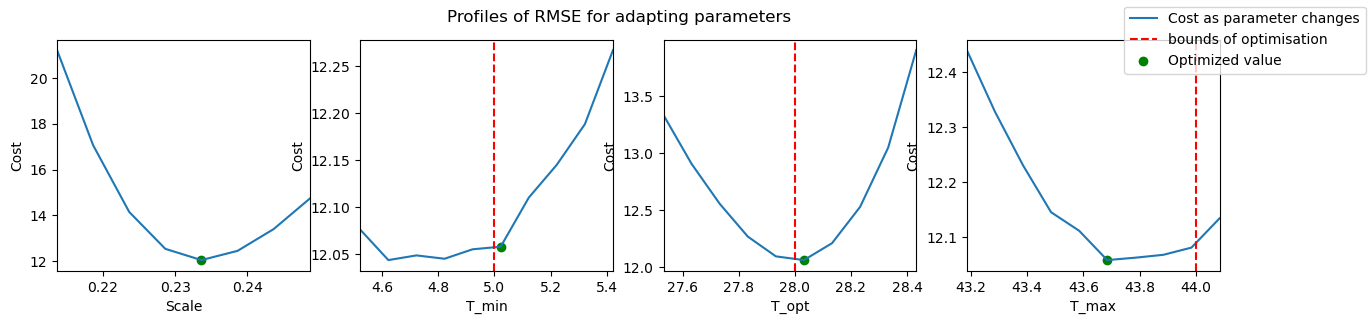

In [19]:
train, test = train_test_split(ds2_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm2s[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])


In [120]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm3s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=200)
train_a, test_a = train_test_split(ds, test_size=0.5, random_state = 1)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +2.0043e+01 | 1.00e+00 | 2.91e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +2.0972e+01 | 7.00e+00 | 4.15e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   5   | +1.5255e+01 | 7.00e+00 | 1.88e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |   4   |   8   | +1.1401e+01 | 7.00e+00 | 1.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |   6   |  12   | +1.1401e+01 | 7.00e-01 | 1.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |   7   |  15   | +1.1347e+01 | 7.00e-01 | 1.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |   8   |  18   | +1.1286e+01 | 7.00e-01 | 1.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |   9   |  21   | +9.5472e+00 | 1.40e+

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  41   |  61   |  72   | +9.5413e+00 | 1.76e-02 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  42   |  63   |  74   | +9.5413e+00 | 8.82e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  43   |  64   |  75   | +9.5413e+00 | 4.41e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  44   |  65   |  76   | +9.5413e+00 | 2.20e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  45   |  67   |  77   | +9.5413e+00 | 9.35e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  46   |  68   |  78   | +9.5413e+00 | 4.67e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  47   |  70   |  79   | +9.5413e+00 | 1.99e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  48   |  72   |  80   | +9.5413e+00 | 4.29e-05 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  49   |  74   |  81   | +9.5413e+00 | 7.43e-06 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  50   |  76   |  82   | +9.5413e+00 | 3.72e-

In [ ]:
plot_profiles_at_minimum(fm3s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [20]:
x1s = [np.array([0.8, 8, 28, 39])]
fm_flowering_all = local_opt(x1s, ds, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.486060
         Iterations: 137
         Function evaluations: 268
[ 0.8  8.  28.  39. ] [ 0.37764873  7.00955167 25.07110728 38.89409373] [0.42235127 0.99044833 2.92889272 0.10590627]
RMSE at opt on test set:  8.490373608261214
R^2: 0.3281956184199428


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


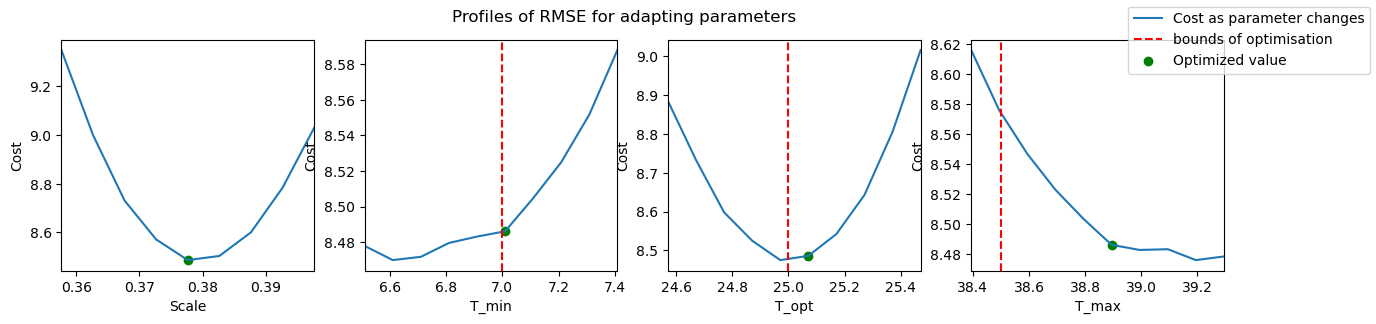

In [23]:
train_a, test_a = train_test_split(ds, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [25]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm5s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.309354
         Iterations: 110
         Function evaluations: 237
[ 0.8  8.  28.  39. ] [ 0.38455098  7.85891439 25.01171837 38.67322138] [0.41544902 0.14108561 2.98828163 0.32677862]
RMSE at opt on test set:  8.268961093512054
R^2: 0.3372506254579203


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


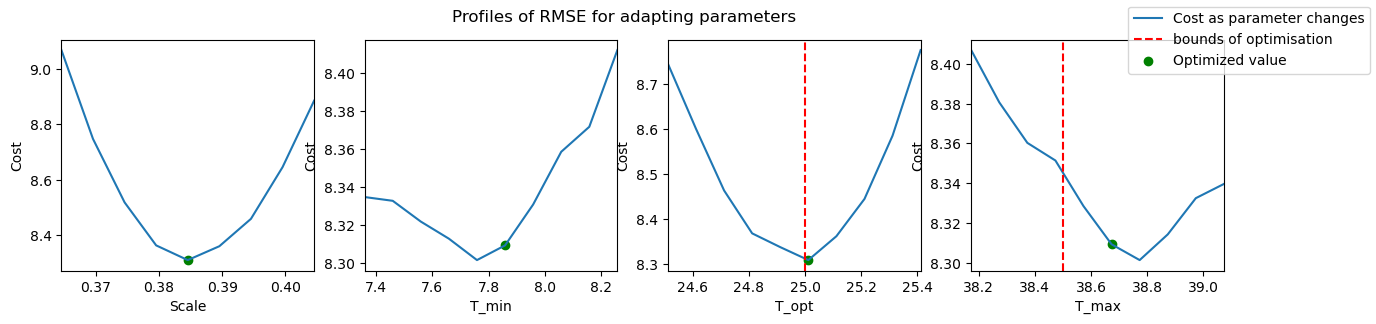

In [26]:
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm5s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [29]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm6s, res = local_opt(x1s, ds_cold, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.683780
         Iterations: 196
         Function evaluations: 353
[ 0.8  8.  28.  39. ] [ 0.37629408  7.08260145 25.02142537 39.63852827] [ 0.42370592  0.91739855  2.97857463 -0.63852827]
RMSE at opt on test set:  8.666066536777695
R^2: 0.35085707964200563


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


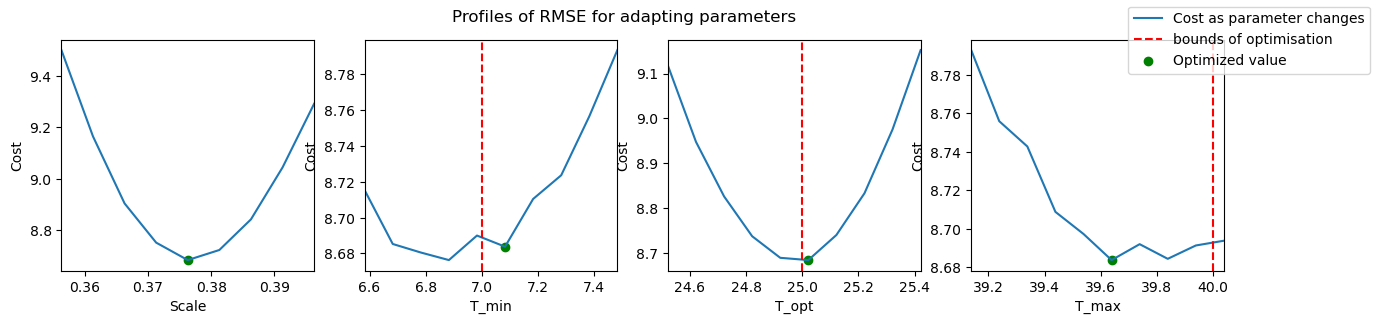

In [30]:
train_a, test_a = train_test_split(ds_cold, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm6s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [36]:
parameter_data = np.concatenate([np.array([fm_all_ripeness[0]]), 
                                 np.array([fm2s[0]]), np.array([fms[0]]), 
                                 np.array([fm_flowering_all[0][0]]), 
                                 np.array([fm5s[0]]), 
                                 np.array([fm6s[0]])], axis=0)

In [47]:
column_names = ['Scale (thermal time requirement)', 'T_min', 'T_opt',  'T_max']
row_names = np.array(['Full set, ripeness', 'Warm set, ripeness', 'Cold set, ripeness',
                      'Full set, flowering', 'Warm set, flowering', 'Cold set, flowering'])
R2s = np.array([-0.029379434800168136, 0.33311833790242984, 0.12521048556632275,
                0.3281956184199428, 0.3372506254579203, 0.35085707964200563])
parameters_frame = pd.DataFrame(parameter_data, columns = column_names, index = row_names)
parameters_frame['R2'] = R2s

In [62]:
np.round(parameters_frame, decimals = 2)

,Scale,T_min,T_opt,T_max,R2
"Full set, ripeness",0.24,5.00,28.16,43.96,-0.03
"Warm set, ripeness",0.23,5.02,28.03,43.68,0.33
"Cold set, ripeness",0.25,5.01,28.02,43.70,0.13
"Full set, flowering",0.38,7.01,25.07,38.89,0.33
"Warm set, flowering",0.38,7.86,25.01,38.67,0.34
"Cold set, flowering",0.38,7.08,25.02,39.64,0.35


In [49]:
def plot_profiles_at_minimum(x_opt, ds, lb=[0.05, 4, 20, 20, 35], ub = [1, 12, 33, 33, 60], 
                             response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
                             growing_period_length = 300, new_unfinished_penalisation=False,
                             thresholds = [100]):
    x_min = x_opt.copy()
    fig, axs = plt.subplots(1, len(x_min), figsize = (15, 3))
    if response_type == 'Trapezoid':
        parameter_names = ['Scale', 'T_min', 'T_opt1', 'T_opt2', 'T_max']
    elif response_type == 'Wang':
        parameter_names = ['Scale', 'T_min', 'T_opt', 'T_max']
    for x_index in range(len(x_min)):
        parameter_name = parameter_names[x_index]
        print(f'Plotting {parameter_name}')
        if x_index == 0:
            x_i = np.arange(x_min[x_index] - 0.02, x_min[x_index] + 0.02, 0.005)#0.002)
        elif x_index > 2:
            x_i = np.arange(x_min[x_index] - 1/2, x_min[x_index] + 1/2, 0.1)#0.05)
        else:
            x_i = np.arange(x_min[x_index] - 1/2, x_min[x_index] + 1/2, 0.1)#0.05)
        RMSEs = np.zeros(x_i.shape)
        for i in range(x_i.shape[0]):
            #print(x_i[i])
            x_for_plotting = x_min.copy()
            x_for_plotting[x_index] = x_i[i]
            RMSEs[i] = run_GDD_and_get_RMSE(x_for_plotting, ds, 't2m', response_type=response_type, phase_list = phase_list,
                                            growing_period_length = growing_period_length, new_unfinished_penalisation=new_unfinished_penalisation,
                                            thresholds = thresholds)
        axs[x_index].plot(x_i, RMSEs, label = 'Cost as parameter changes')
        axs[x_index].axvline(lb[x_index], linestyle = '--', color = 'red', label = 'bounds of optimisation')
        axs[x_index].axvline(ub[x_index], linestyle = '--', color = 'red')
        #axs[x_index].axvline(x_min[x_index], color = 'green', label = 'Optimized value')
        axs[x_index].scatter(x_min[x_index], 
                             run_GDD_and_get_RMSE(x_min, ds, 't2m', response_type=response_type, phase_list = phase_list,
                                                  growing_period_length = growing_period_length, new_unfinished_penalisation=new_unfinished_penalisation,
                                                  thresholds = thresholds),
                            color = 'green', label = 'Optimized value')
        axs[x_index].set_xlim(x_i.min(), x_i.max())
        axs[x_index].set(xlabel = parameter_name)
        axs[x_index].set(ylabel = 'Cost')
        if x_index == 0:
            fig.legend()
    fig.suptitle('Profiles of RMSE for adapting parameters')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.294785015679883
            Iterations: 31
            Function evaluations: 101
            Gradient evaluations: 31
[ 0.8  8.  28.  39. ] [ 0.35817842  7.         25.         40.        ] [ 0.44182158  1.          3.         -1.        ]
RMSE at opt on test set:  8.329018490771157
R^2: 0.35004877727464745
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


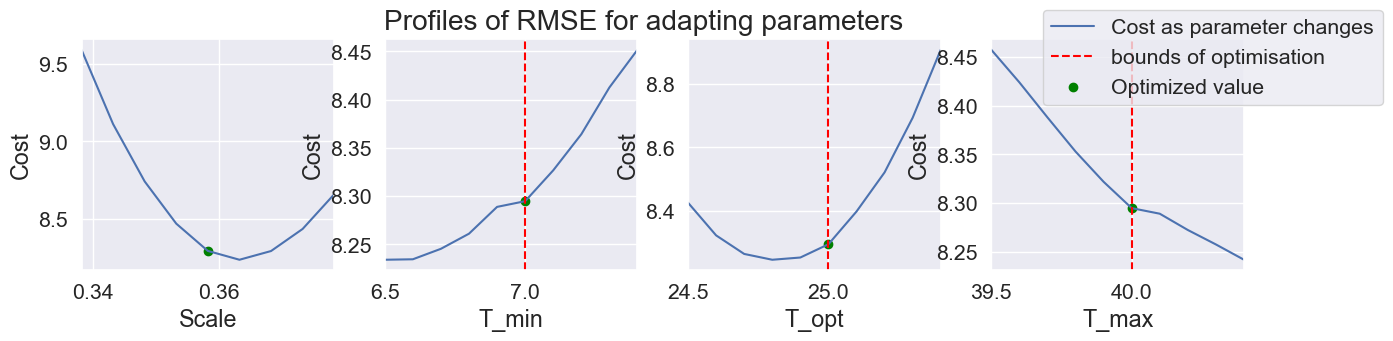

In [121]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm4s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='SLSQP',
                     thresholds = [20], growing_period_length=200)
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm4s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [24]:
#x1s = [np.array([1.5, 6, 29.5, 42])]
#fm2s, res = local_opt(x1s, ds2, 
#                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
#                     great_threshold = 13, response_type = 'Wang',
#                     phase_list = ['yellow ripeness'],
#                     method='trust-constr',
#                     thresholds = [20], growing_period_length=200)
#train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
#plot_profiles_at_minimum(fm2s[0], train, #fm2s[0], ds2, #fm2s[0]
#                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
#                         response_type = 'Wang', phase_list = ['yellow ripeness'],
#                         growing_period_length=200, new_unfinished_penalisation=False,
#                         thresholds = [20])

In [19]:
def one_by_one_optimisation(x0, ds, lb, ub, phase_list = ['yellow ripeness'], thresholds = [10], growing_period_length = 200, response_type = 'Wang', ):
    fixed_params = x0.copy()[1:].tolist()
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})

    T_min = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, x] + fixed_params[1:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[1], ub[1]),
                                                method='bounded',
                                                options = {'disp': 3})
                            
    T_opt = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, x] + fixed_params[2:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[2], ub[2]),
                                                method='bounded',
                                                options = {'disp': 3})
    T_max = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, T_opt.x, x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[3], ub[3]),
                                                method='bounded',
                                                options = {'disp': 3})

    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x, T_min.x, T_opt.x, T_max.x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})


    x_opt = [x_0.x, T_min.x, T_opt.x, T_max.x]
    return x_opt

In [20]:
x_opt = one_by_one_optimisation(fm3s[0], train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200,
                         thresholds = [20])

 
 Func-count     x          f(x)          Procedure
    1        1.91601      46.0385        initial
    2        3.09399      55.7688        golden
    3        1.18798       33.381        golden
    4       0.738031      16.4724        golden
    5       0.459948      17.5153        golden
    6       0.632022      10.8563        parabolic
    7       0.604678      9.86623        parabolic
    8       0.549396      9.82621        golden
    9       0.576194      9.44314        parabolic
   10        0.57635      9.44053        parabolic
   11        0.58717      9.52115        golden
   12       0.580067      9.44998        parabolic
   13       0.577953      9.45067        parabolic
   14       0.576354      9.44093        parabolic
   15       0.576282      9.44159        parabolic
   16       0.576324      9.44061        golden
   17       0.576338      9.44071        parabolic
   18       0.576345       9.4405        golden
   19       0.576342      9.44068        parabolic

Opt

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


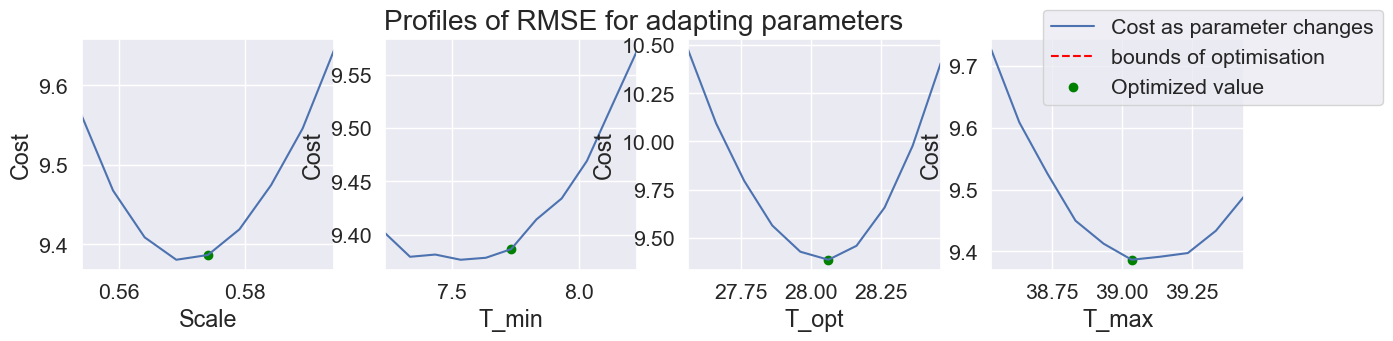

In [23]:
plot_profiles_at_minimum(x_opt, train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [93]:
#run_GDD_and_get_RMSE_derivs(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'])

[22.39799260278446,
 -1.4147834521381712,
 -6.269908938762039,
 2.5552586947730322]

In [35]:
def global_search(ds, param_values,
                     N = 200, 
                     interesting_threshold = 16, great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness']):
    np.random.seed(10)
    count_tested = 0
    results_array = pd.DataFrame(columns = ['Tmin', 'Topt', 'Tmax', 'optimised scale', 'RMSE'])
    for Tmin_index, Tmin in enumerate(param_values[0]):
        for Topt_index, Topt in enumerate(param_values[1]):
            for Tmax_index, Tmax in enumerate(param_values[2]):
                x0 = [0.12, Tmin, Topt, Tmax]
                constraint_violation = x0[1] < x0[0] or x0[2] < x0[1]
                if constraint_violation:
                    print(x0, 'goes against constraints')
                    continue
                fixed_params = [Tmin, Topt, Tmax]
                x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type=response_type, phase_list = phase_list),
                                                    bounds = (0.05, 1.5),
                                                    method='bounded',
                                                    options = {'disp': 2})
                x1 = np.array([x_0.x] + fixed_params)
                opt_value = run_GDD_and_get_RMSE(x1, ds, 't2m', response_type=response_type,  phase_list = phase_list)
                new_row = pd.DataFrame({'Tmin':[Tmin], 'Topt':[Topt], 'Tmax':[Tmax], 'optimised scale':[x1[0]], 'RMSE':[opt_value]})
                count_tested += 1
                print(f'{count_tested} samples considered')
                results_array = pd.concat([results_array, new_row])
                print(results_array)
    return results_array

In [26]:
#rar2 = global_search(ds2, param_values = [[5,6,7], [29.5, 31, 32.5], [40, 42, 44]])#[[7, 8, 9], [29, 30, 31], [38, 40, 42]])

In [40]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
fixed_params = fm2s[0][1:].copy().tolist()
x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, train, 't2m', response_type='Wang', phase_list = ['yellow ripeness']),
                                            bounds = (0.05, 5),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1        1.94073      49.2621        initial
    2        3.10927      75.3839        golden
    3        1.21854       16.311        golden
    4       0.772195      164.642        golden
    5        1.49439      29.9145        golden
    6        1.04805      55.1741        golden
    7         1.3239      19.5595        golden
    8        1.12904      27.9912        parabolic
    9         1.2526      15.9918        parabolic
   10        1.24388       15.773        parabolic
   11        1.23902      15.6395        parabolic
   12        1.23119      15.7864        golden
   13        1.23768      15.6039        parabolic
   14         1.2352        15.73        golden
   15        1.23769      15.6039        parabolic
   16        1.23759      15.6021        parabolic
   17        1.23668      15.5719        golden
   18        1.23611      15.7517        golden
   19        1.23703      15.5865        golden
   20        

In [53]:
def run_GDD_and_scatter_plot(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                             phase_list = ['beginning of flowering'], exclude_unfinished = False,
                             growing_period_length = 300, thresholds = [100], 
                             title_extra=''):
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(growing_period_length):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    fig, axs = plt.subplots(1, len(phase_list), figsize = (len(phase_list)*5, 5))
    for phase_index, phase in enumerate(phase_list):
        number_unfinished = (comparison_array[f'modelled time to {phase}'] >= growing_period_length).sum()
        number_total = len(comparison_array)
        print(f'{number_unfinished} stations out of {number_total} did not reach the end of phase \'{phase}\'')
        if exclude_unfinished:
            comparison_array = comparison_array[comparison_array[f'modelled time to {phase}'] < growing_period_length].dropna()
        comparison_array[f'observed time to {phase}'] = comparison_array[f'observed time to {phase}'].dt.days
        if len(phase_list) == 1:
            #x_estimator=np.mean,
            minval = min(comparison_array[f'observed time to {phase}'].min(), comparison_array[f'modelled time to {phase}'].min()) - 1
            maxval = max(comparison_array[f'observed time to {phase}'].max(), comparison_array[f'modelled time to {phase}'].max()) + 1
            sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=comparison_array, ax=axs,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
            axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
            axs.set_xlim(minval, maxval)
            axs.set_ylim(minval, maxval)
            axs.set_title(f'Comparison of modelled and observed time to {phase}\n{title_extra}')

        else:
            sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=comparison_array, ax=axs[phase_index],
                        scatter_kws={'alpha':0.5, 's':4})
            minval = min(comparison_array[f'observed time to {phase}'].min(), comparison_array[f'modelled time to {phase}'].min()) - 1
            maxval = max(comparison_array[f'observed time to {phase}'].max(), comparison_array[f'modelled time to {phase}'].max()) + 1
            axs[phase_index].set_xlim(minval, maxval)
            axs[phase_index].set_ylim(minval, maxval)
    rsquared = r2_score(comparison_array[f'observed time to {phase}'], comparison_array[f'modelled time to {phase}'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_array[f'observed time to {phase}'].mean() - comparison_array[f'modelled time to {phase}'].mean()
    variance_modelled = comparison_array[f'modelled time to {phase}'].var()
    print(f'Bias: {bias**2} (sign {np.sign(bias)})\nVariance of modelled values: {variance_modelled}')
    return comparison_array

In [126]:
ds2_warm['observed time to yellow ripeness'].max()

Timedelta('181 days 00:00:00')

In [143]:
print(len(ds2_warm), len(ds2_cold))

5080 2807


8 stations out of 1404 did not reach the end of phase 'yellow ripeness'
R^2 value for model: 0.07936085266295356
Bias: 8.17780750562087 (sign 1.0)
Variance of modelled values: 200.14510369517527


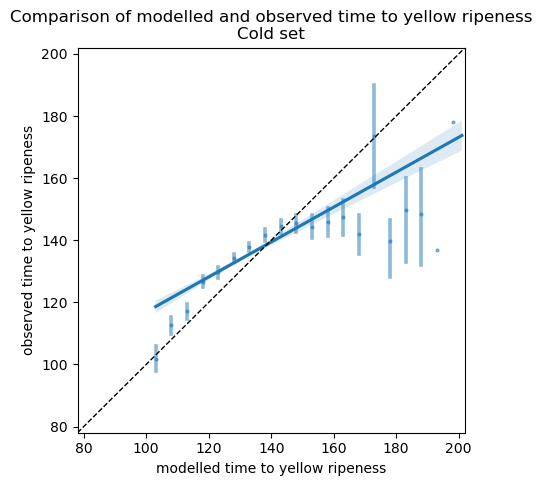

In [54]:
train, test = train_test_split(ds2_cold, test_size=0.5, random_state = 1)
ca_ripeness_cold = run_GDD_and_scatter_plot(fms[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Cold set')

0 stations out of 2540 did not reach the end of phase 'yellow ripeness'
R^2 value for model: 0.33285568265938137
Bias: 0.4453197656395564 (sign 1.0)
Variance of modelled values: 121.66391008922236


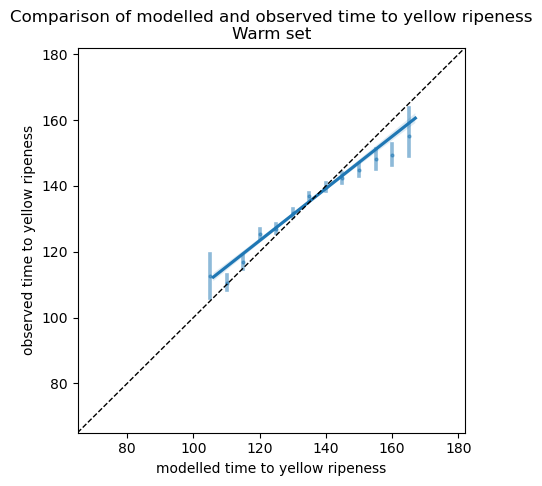

In [55]:
train, test = train_test_split(ds2_warm, test_size=0.5, random_state = 1)
ca_ripeness = run_GDD_and_scatter_plot(fm2s[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Warm set')

39 stations out of 3944 did not reach the end of phase 'yellow ripeness'
R^2 value for model: -0.029640499835624334
Bias: 2.9421295320080136 (sign 1.0)
Variance of modelled values: 221.68053374943779


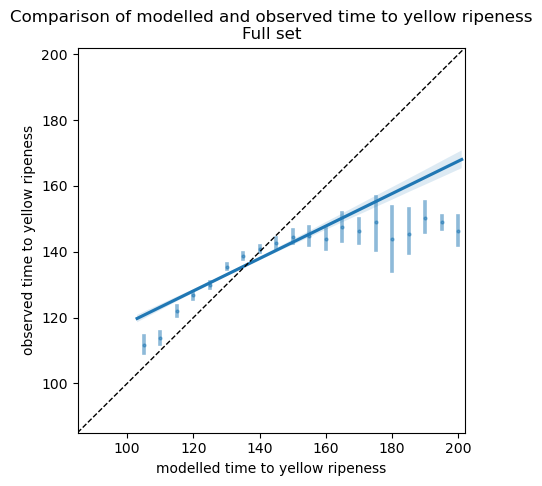

In [56]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
ca_ripeness = run_GDD_and_scatter_plot(fm_all_ripeness[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Full set')

0 stations out of 5599 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.328075610491839
Bias: 0.04262797802059545 (sign -1.0)
Variance of modelled values: 54.411153206363814


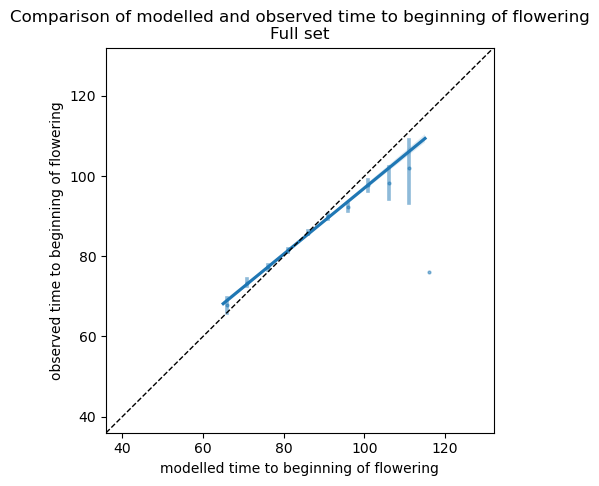

In [58]:
train_a, test_a = train_test_split(ds, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm_flowering_all[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Full set')

0 stations out of 3484 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3370603442708511
Bias: 0.01272415081705384 (sign 1.0)
Variance of modelled values: 52.864617728293425


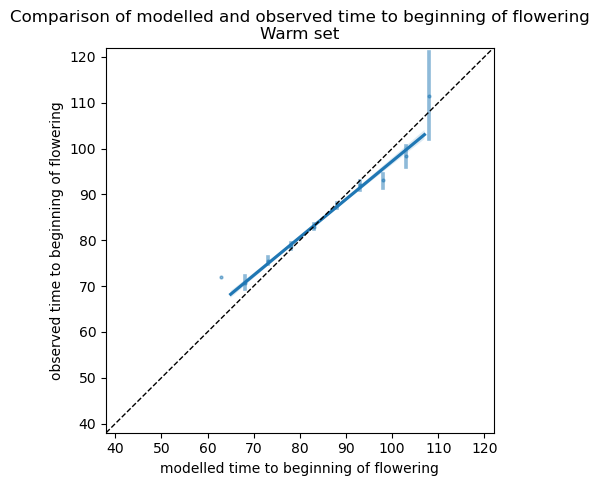

In [60]:
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm5s[0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Warm set')

0 stations out of 2115 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3505500110893277
Bias: 0.015817670696199153 (sign -1.0)
Variance of modelled values: 52.15977374745873


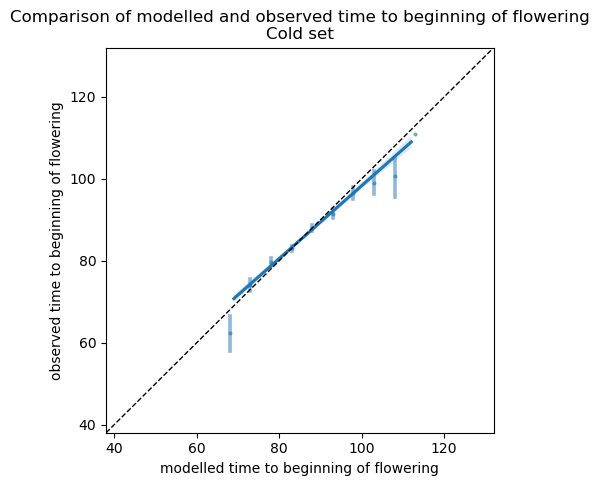

In [61]:
train_a, test_a = train_test_split(ds_cold, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm6s[0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Cold set')

0 stations out of 5599 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.16468430613847995
Bias: 0.3049706430558551
Variance of modelled values: 98.71395226307803


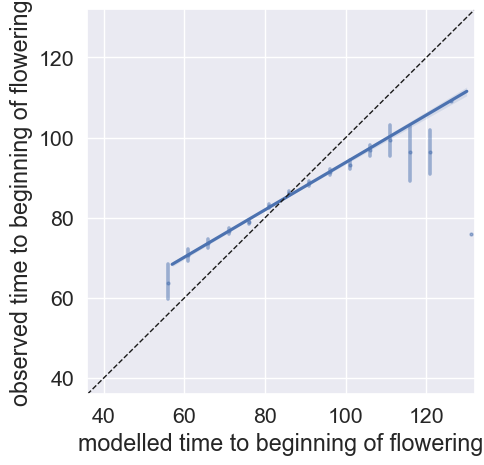

In [41]:
ca_flowering_2nd_min = run_GDD_and_scatter_plot(x_opt, test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, thresholds = [20])

In [23]:
ca_not_matured = ca_ripeness.where(ca_ripeness['modelled time to yellow ripeness'] ==201).dropna()
ca_not_matured = get_station_locations(ca_not_matured, Maize_set.station_data)
ca_not_matured[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/canm_latlon2.csv')
ca_not_matured['Referenzjahr'].unique()

array([2002., 2004., 2010., 2008., 2015., 2007., 2012.])

In [127]:
ca_late_matured = ca_ripeness.where(ca_ripeness['modelled time to yellow ripeness'] > 160).dropna()
ca_late_matured = get_station_locations(ca_late_matured, Maize_set.station_data)
ca_late_matured[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/calm_latlon3.csv')
ca_late_matured['Referenzjahr'].unique()

array([2015., 2010., 2004., 2012.])

In [128]:
ca_bad_flowering = ca_flowering.where(ca_flowering['modelled time to beginning of flowering'] > 100).dropna()
ca_bad_flowering = get_station_locations(ca_bad_flowering, Maize_set.station_data)
ca_bad_flowering[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/cabf_latlon3.csv')

In [65]:
print(run_GDD_and_get_RMSE(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'], new_unfinished_penalisation=True),
      run_GDD_and_get_RMSE(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'], new_unfinished_penalisation=False))

0 7767
21.37204687891441 28.512367772840147


In [31]:
canm['temp mean'] = canm[[f'temperature at day {day}' for day in range(185)]].mean(axis=1)

In [33]:
ca['temp mean'] = ca[[f'temperature at day {day}' for day in range(185)]].mean(axis=1)

In [38]:
print(ca['temp mean'].std(), canm['temp mean'].std())

1.0500583242020791 0.3395458100742532


In [45]:
canm = get_station_locations(canm, Maize_set.station_data)
canm[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/canm_latlon.csv')
canm['Referenzjahr'].unique()
canm = ca.where(ca['modelled time to yellow ripeness'] ==186).dropna()

In [72]:
x0 = np.array([11.36, 5.757, 22.68, 25.17, 45])
x0 = np.array([11.36, 5.757, 22.68, 35, 45])
x0 = np.array([1, 5.757, 26, 45])
x0 = fm2s[0]
thresholds = [20]
phase_list = ['yellow ripeness']
ds = train
grad_algebraic = run_GDD_and_get_RMSE_derivs(x0, ds.drop_duplicates(), 't2m', response_type = 'Wang',
                                             thresholds = thresholds, phase_list = phase_list)
for h in [0.00005, 0.0001, 0.001]:#, 0.01, 0.1]:
    grads_numeric0 = []
    grads_numeric1 = []
    grads_numeric2 = []
    for x_index in range(len(x0)):
        x_plus_h = x0
        x_minus_h =  x0
        h_perturb = [0 for count in range(len(x0))]
        h_perturb[x_index] = h
        h_perturb = np.array(h_perturb)
        x_plus_h = x_plus_h + h_perturb
        x_minus_h = x_minus_h - h_perturb
        #print(x_minus_h, x_plus_h)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = 'Wang', thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = 'Wang', thresholds = thresholds, phase_list = phase_list))/(2*h)
        grads_numeric0.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = 'Wang', thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = 'Wang', thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric1.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = 'Wang', thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = 'Wang', thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric2.append(grad_numeric)
    
    print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic)

[-1292.5468879190305, -2.7218698514275275, -3.9083131800410342, 2.7218698514275275] [81.50798186044028, 0.0, 0.0, 5.443739702855055] [-2666.601757698501, -5.443739702855055, -7.8166263600820685, 0.0] [-202.91674872518774, 3.157642170902563, 6.9215807791176225, -2.7095578619232334]
[-1274.0800070536727, -1.9541565900205171, 4.850178188871013, 1.9541565900205171] [-1228.0235000203631, 0.0, 18.70330873369852, 3.9083131800410342] [-1320.1365140869825, -3.9083131800410342, -9.002952355956495, 0.0] [-202.91674872518774, 3.157642170902563, 6.9215807791176225, -2.7095578619232334]
[-395.86769324261263, 0.432652759204899, 1.6780339956827817, -0.3872948201770754] [-348.30672062962617, 2.868227168267623, 6.712755886493227, 2.0099000849782556] [-443.42866585559904, -2.002921649857825, -3.3566878951276635, -2.7844897253324064] [-202.91674872518774, 3.157642170902563, 6.9215807791176225, -2.7095578619232334]


In [251]:
T_min_values = np.arange(0, 7, 0.5)
T_opt1_values = np.arange(15, 23, 0.5)
T_mins, T_opt1s = np.meshgrid(T_min_values, T_opt1_values)
RMSEs = np.zeros(T_mins.shape)
for i in range(T_mins.shape[0]):
    print(T_opt1_values[i])
    for j in range(T_mins.shape[1]):
        RMSEs[i, j] = run_GDD_and_get_RMSE(np.array([10, T_mins[i, j], T_opt1s[i, j], 35, 45]), ds, 't2m')

15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5


In [73]:
scale_values = np.arange(0.7, 1.3, 0.05)
T_opt1_values = np.arange(15, 25, 0.5)
scales, T_opt1s = np.meshgrid(scale_values, T_opt1_values)
RMSE2s = np.zeros(T_opt1s.shape)
for i in range(T_opt1s.shape[0]):
    print(T_opt1_values[i])
    for j in range(T_opt1s.shape[1]):
        RMSE2s[i, j] = run_GDD_and_get_RMSE(np.array([scales[i, j], 0, T_opt1s[i, j], 35, 45]), ds, 't2m')

15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5


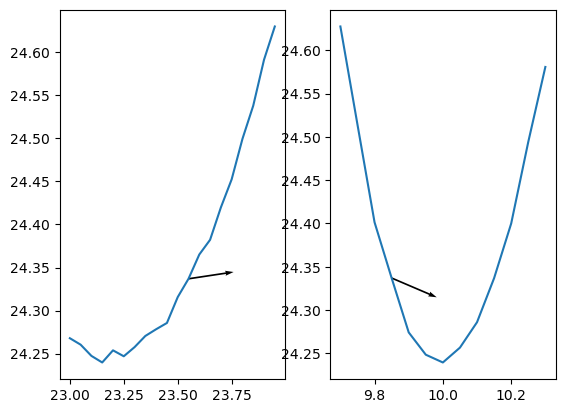

In [272]:
fig, ax = plt.subplots(1, 2)
scaleindex = 3
Toptindex = 11
scale_values = np.arange(9.7, 10.3, 0.05)
T_opt1_values = np.arange(23, 24, 0.05)
scales, T_opt1s = np.meshgrid(scale_values, T_opt1_values)
derivs = run_GDD_and_get_RMSE_derivs(np.array([scales[Toptindex, scaleindex], 0, T_opt1s[Toptindex, scaleindex], 35, 45]), ds, 't2m')
ax[0].plot(T_opt1s[:, scaleindex], RMSE2s[:, scaleindex], )
ax[0].quiver(T_opt1s[Toptindex, scaleindex], RMSE2s[Toptindex, scaleindex], 1, derivs[2], scale = 5)
ax[1].plot(scales[Toptindex, :], RMSE2s[Toptindex, :], )
ax[1].quiver(scales[Toptindex, scaleindex], RMSE2s[Toptindex, scaleindex], 1, derivs[0], scale = 5)

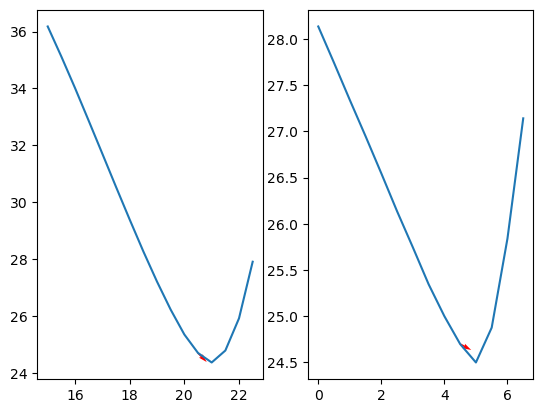

In [260]:
T_min_values = np.arange(0, 7, 0.5)
T_opt1_values = np.arange(15, 23, 0.5)
T_mins, T_opt1s = np.meshgrid(T_min_values, T_opt1_values)
fig, ax = plt.subplots(1, 2)
Tminindex = 11
Toptindex = 9
derivs = run_GDD_and_get_RMSE_derivs(np.array([10, T_mins[Tminindex, Toptindex], T_opt1s[Tminindex, Toptindex], 35, 45]), ds, 't2m')
ax[0].plot(T_opt1s[:, Toptindex], RMSEs[:, Toptindex], )
ax[0].quiver(T_opt1s[Tminindex, Toptindex], RMSEs[Tminindex, Toptindex], 5, 5*derivs[2], color='red')
ax[1].plot(T_mins[Tminindex, :], RMSEs[Tminindex, :], )
ax[1].quiver(T_mins[Tminindex, Toptindex], RMSEs[Tminindex, Toptindex], 5, 5*derivs[1], color='red')

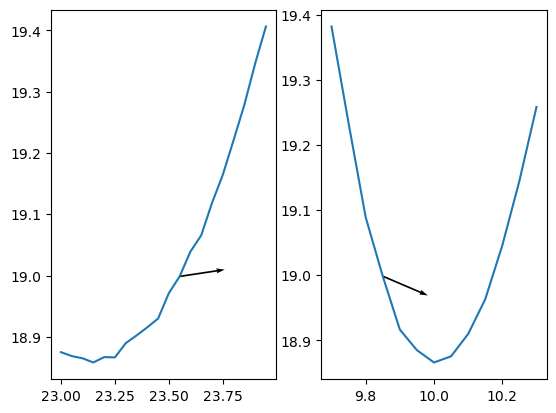

18.85502652987415 T_opt1 = 23.950000000000014 scale = 10.300000000000008


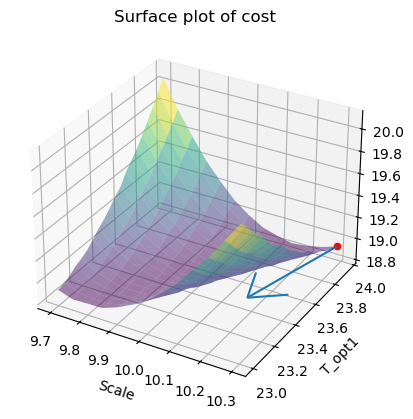

In [230]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(scales, T_opt1s, RMSE2s, cmap='viridis', alpha = 0.5)
ax.set(xlabel = 'Scale')
ax.set(ylabel = 'T_opt1')
ax.set_title('Surface plot of cost')
mindex = np.unravel_index(np.argmin(RMSE2s), T_opt1s.shape)
mindex = (-1, -1)
ax.scatter(scales[mindex], T_opt1s[mindex], RMSE2s[mindex], color = 'red', s=20)
print(RMSE2s.min(), f'T_opt1 = {T_opt1s[mindex]}', f'scale = {scales[mindex]}')


# Make the direction data for the arrows
derivs = run_GDD_and_get_RMSE_derivs(np.array([scales[mindex], 0, T_opt1s[mindex], 35, 45]), ds, 't2m')

ax.quiver(scales[mindex], T_opt1s[mindex], RMSE2s[mindex], -derivs[0], -derivs[2], -3, length=1, normalize=True)

18.85502652987415 T_opt1 = 23.450000000000006 scale = 9.950000000000003


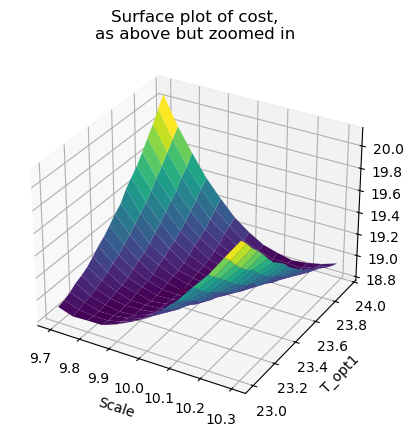

In [95]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(scales, T_opt1s, RMSE2s, cmap='viridis')
ax.set(xlabel = 'Scale')
ax.set(ylabel = 'T_opt1')
ax.set_title('Surface plot of cost,\nas above but zoomed in')
mindex = np.unravel_index(np.argmin(RMSE2s), T_opt1s.shape)
ax.scatter(scales[mindex], T_opt1s[mindex], RMSE2s[mindex], color = 'red')
print(RMSE2s.min(), f'T_opt1 = {T_opt1s[mindex]}', f'scale = {scales[mindex]}')

In [57]:
ds['Referenzjahr'].min()

2019.0

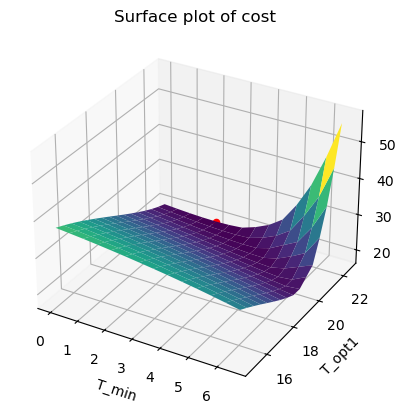

In [86]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(T_mins, T_opt1s, RMSEs, cmap='viridis')
ax.set(xlabel = 'T_min', ylabel = 'T_opt1')
ax.set_title('Surface plot of cost')
mindex = np.unravel_index(np.argmin(RMSEs), T_mins.shape)
ax.scatter(T_mins[mindex], T_opt1s[mindex], RMSEs[mindex], color = 'red')
print(RMSEs.min(), f'T_opt1 = {T_opt1s[mindex]}', f'T_min = {T_mins[mindex]}')

In [54]:
mindex = np.unravel_index(np.argmin(RMSEs), T_mins.shape)
print(mindex)
print(T_mins[np.argmin(RMSEs, keepdims=True)])

(44, 0)


IndexError: index 2200 is out of bounds for axis 0 with size 50

In [ ]:
ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([x[1] - 0, 
                                         10 - x[1], 
                                         x[2] - 10,
                                         25 - x[2],
                                         x[3] - 20,
                                         35 - x[3],
                                         x[4] - 35,
                                         50 - x[4],
                                         x[2] - x[1],
                                         x[3] - x[2],
                                         x[4] - x[3]]),
             'jac' : lambda x: np.array([[0, 1, 0, 0, 0],
                                         [0, -1, 0, 0, 0],
                                         [0, 0, 1, 0, 0],
                                         [0, 0, -1, 0, 0],
                                         [0, 0, 0, 1, 0],
                                         [0, 0, 0, -1, 0],
                                         [0, 0, 0, 0, 1],
                                         [0, 0, 0, 0, -1],
                                         [0, -1, 1, 0, 0],
                                         [0, 0, -1, 1, 0],
                                         [0, 0, 0, -1, 1]])}

In [293]:

#x_opt = scipy.optimize.shgo(lambda x: run_GDD_and_get_RMSE(x, ds, 't2m'), 
#                            bounds=bounds, constraints=constraints, iters=10, sampling_method='simplicial',
#                            minimizer_kwargs={'method':'SLSQP',
#                                              'jac': lambda x: run_GDD_and_get_RMSE_derivs(x, ds, 't2m')}
#                            )

Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.383317850047465
            Iterations: 6
            Function evaluations: 89
            Gradient evaluations: 6
[1.16143056e+00 6.51127978e-03 2.69762720e+01 3.50000000e+01
 4.50000000e+01]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 25.473506592266318
            Iterations: 2
            Function evaluations: 32
            Gradient evaluations: 2
[ 1.06575324  6.         20.         22.         35.        ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.259566337662655
            Iterations: 5
            Function evaluations: 63
            Gradient evaluations: 5
[ 1.42916318  1.         32.47872763 32.47872763 45.        ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.45390472920437
            Iterations: 7
            Function evaluations: 103
  

In [ ]:
x_opt3 = scipy.optimize.basinhopping(run_GDD_and_get_RMSE, x0=[1 , 8, 28, 36], niter = 5,
                        minimizer_kwargs={'args':(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m'),
                                          'method': 'Nelder-Mead'})
                        #method='Nelder-Mead')

In [10]:
dev_time_frame = pd.DataFrame(Maize_set.model_dev_time_series.T, columns=[f't_dev at day {n}' for n in range(301)] + ['Referenzjahr', 'Stations_id'])
dev_time_frame['Referenzjahr'] = pd.to_datetime(dev_time_frame['Referenzjahr']).dt.year
obs_ds = Maize_set.ds_observed.dropna(subset=['emergence date'])
ds_optimising = pd.merge(dev_time_frame, obs_ds, how='left', on=['Referenzjahr', 'Stations_id'])
ds_optimising = ds_optimising.merge(Maize_set.just_emergence[['Stations_id', 'Referenzjahr', 'WC SOS date']], how='outer', on=['Referenzjahr', 'Stations_id'])
ds_optimising = ds_optimising.dropna()

In [11]:
ds_optimising = ds_optimising.where(ds_optimising['emergence date'] > ds_optimising['WC SOS date']).dropna()
ds_optimising = ds_optimising.where(ds_optimising['observed time to beginning of flowering'] >0).dropna()
ds_optimising = ds_optimising.where(ds_optimising['observed time to yellow ripeness'] >0).dropna()
ds_optimising['emergence index'] = (ds_optimising['emergence date'] - ds_optimising['WC SOS date']).dt.days.astype('int64')
ds_optimising['flowering index'] = (ds_optimising['observed time to beginning of flowering'] + ds_optimising['emergence index']).astype('int64')
ds_optimising['yellow ripeness index'] = (ds_optimising['observed time to yellow ripeness'] + ds_optimising['emergence index']).astype('int64')


In [12]:
ds_optimising['dev time at observed emergence'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "emergence index"]}'] for i in ds_optimising.index]
ds_optimising['dev time at observed flowering'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "flowering index"]}'] for i in ds_optimising.index]
ds_optimising['dev time at observed ripeness'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "yellow ripeness index"]}'] for i in ds_optimising.index]#
#ds_optimising['flowering index'] = (ds_optimising['observed time to beginning of flowering'] + ds_optimising['emergence index']).astype('int64')
#ds_optimising['yellow ripeness index'] = (ds_optimising['observed time to yellow ripeness'] + ds_optimising['emergence index']).astype('int64')

In [13]:
ds_optimising['coeff for emergence'] = 1/ds_optimising['dev time at observed emergence']
ds_optimising['coeff for flowering'] = 1/(ds_optimising['dev time at observed flowering'] - ds_optimising['dev time at observed emergence'])
ds_optimising['coeff for ripeness'] = 1/(ds_optimising['dev time at observed ripeness'] - ds_optimising['dev time at observed flowering'])

In [ ]:
#ds_optimising.where(ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna()

(array([2.017e+03, 7.800e+01, 9.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([0.08260219, 0.90126075, 1.7199193 , 2.53857786, 3.35723642,
        4.17589498, 4.99455353, 5.81321209, 6.63187065, 7.4505292 ,
        8.26918776]),
 <BarContainer object of 10 artists>)

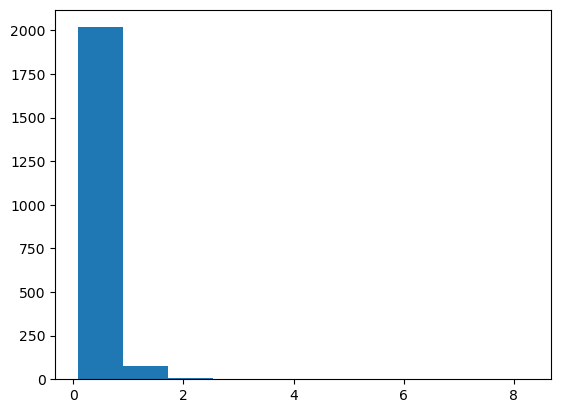

In [14]:
plt.hist(ds_optimising.where((~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf]))*(ds_optimising['coeff for emergence']<10))['coeff for emergence'])#, bins = 20)#[[f't_dev at day {n}' for n in range(200, 300)]]

In [15]:
print(ds_optimising['coeff for emergence'].where(~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna().mean(),
      ds_optimising['coeff for flowering'].where(~ds_optimising['coeff for flowering'].isin([np.inf, -np.inf])).dropna().mean(),
      ds_optimising['coeff for ripeness'].where(~ds_optimising['coeff for ripeness'].isin([np.inf, -np.inf])).dropna().mean())

1.008325157733615 0.03658492936480077 0.04598812328016307


In [16]:
print(ds_optimising['coeff for emergence'].where(~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna().sample(frac=0.5, replace=False).mean(),
      ds_optimising['coeff for flowering'].where(~ds_optimising['coeff for flowering'].isin([np.inf, -np.inf])).dropna().sample(frac=0.5, replace=False).mean(),
      ds_optimising['coeff for ripeness'].where(~ds_optimising['coeff for ripeness'].isin([np.inf, -np.inf])).dropna().sample(frac=0.5, replace=False).mean())

0.5224664530661277 0.03679363293654118 0.04609247795575865


In [9]:
Maize_set.driver_frame_for_ML.dropna(subset = ['t2m day 0', 'observed time to beginning of flowering'])

,Referenzjahr,Stations_id,t2m day 0,t2m day 1,t2m day 2,t2m day 3,t2m day 4,t2m day 5,t2m day 6,t2m day 7,...,lat,lon,WC SOS,observed time to beginning of flowering,observed time to yellow ripeness,emergence date,index,1,2,3
0,2018,7521.0,8.120025,9.939544,10.950083,14.139244,15.773655,16.335490,11.732658,11.085273,...,54.4333,9.8167,2018-04-15,63.0,108.0,2018-05-16,1168.0,6.0,23.0,26.0
2,2018,7592.0,10.922219,11.834785,12.222355,15.646608,17.160594,18.613257,13.832406,14.057785,...,53.4833,10.6333,2018-04-15,73.0,NaN,2018-05-09,1176.0,5.0,8.0,22.0
4,2018,7623.0,7.296997,8.153608,9.499900,10.779305,13.222063,16.031335,14.912643,10.333736,...,54.6667,9.1333,2018-04-14,57.0,101.0,2018-05-16,1188.0,7.0,25.0,28.0
8,2018,7650.0,9.047308,9.000225,11.001043,14.564890,15.288866,17.350146,12.384319,11.619438,...,54.1000,10.8167,2018-04-15,55.0,NaN,2018-05-15,1203.0,6.0,21.0,25.0
9,2018,7662.0,10.081076,11.064128,11.900764,15.448747,17.400507,17.795941,12.594860,13.485576,...,53.7333,9.7833,2018-04-15,67.0,NaN,2018-05-12,1207.0,5.0,13.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,2023,19587.0,8.619230,8.965848,7.935543,5.424142,8.375292,13.165038,12.760963,10.014807,...,48.7091,9.2147,2023-04-17,49.0,123.0,2023-05-27,1157.0,12.0,21.0,33.0
4743,2023,19612.0,8.005281,8.702751,8.217714,6.974363,7.396445,12.911571,15.088900,14.059357,...,52.0507,10.6362,2023-04-16,84.0,121.0,2023-05-18,1160.0,9.0,26.0,35.0
4745,2023,19700.0,5.713335,5.448902,5.580967,11.116664,13.444157,12.497634,9.555045,6.330438,...,50.4316,11.9443,2023-04-18,78.0,132.0,2023-05-19,1163.0,15.0,33.0,36.0
4746,2023,19722.0,4.639520,8.890347,12.034398,11.776999,9.284203,6.104116,6.753432,10.141732,...,47.8655,9.0147,2023-04-20,55.0,109.0,2023-05-21,1164.0,11.0,19.0,33.0


In [3]:
address1 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_akt.txt"
address2 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt"
pd1 = pd.read_csv(address1, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd2 = pd.read_csv(address2, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd3 = pd.concat([pd1, pd2], axis = 0)
pd3 = pd3.drop('Unnamed: 9', axis = 1)
pd3.drop_duplicates(inplace=True)
pd3.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv')
address3 = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv'
pd4 = pd.read_csv(address3)

In [78]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
thresholds = [0.1, 1, 2]
RMSE_list = []
coord_list = []
Maize_set.get_observed_dataset()
for coeff_1 in np.arange(0.02, 0.09, 0.005):
    for coeff_2 in np.arange(0.02, 0.09, 0.005):
        print([coeff_1, coeff_2])
        resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
        #[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
        Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                                    'tas', thresholds[-1])
        Maize_set.get_phase_dates(thresholds)
        for index, phase in enumerate(phase_list2):
            Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
        Maize_set.phase_dates_array = Maize_set.phase_dates_array.where(Maize_set.phase_dates_array['modelled time to yellow ripeness'] < 200)
        Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
        Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to beginning of flowering']
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])



[0.02, 0.02]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 105. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.025]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.030000000000000002]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.035]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.04000000000000001]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.045000000000000005]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


KeyboardInterrupt: 

In [ ]:
phase_dates_array
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])

In [22]:
print(coord_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()],
      RMSE_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()])

[0.02, 0.02] [nan, nan, nan]


In [25]:
ds_comparison#.dropna(subset = ['modelled time to beginning of flowering'])

,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness
0,1951.0,7617.0,29.0,NaN,54.6167,9.0333,NaT,NaN,NaN,NaN
1,1951.0,7899.0,80.0,NaN,52.0833,9.5667,NaT,NaN,NaN,NaN
2,1951.0,8137.0,50.0,NaN,52.8667,9.6000,NaT,NaN,NaN,NaN
3,1951.0,8191.0,54.0,NaN,53.2667,10.1167,NaT,NaN,NaN,NaN
4,1951.0,8234.0,98.0,NaN,52.9333,11.1167,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0
28905,2023.0,19770.0,NaN,NaN,NaN,NaN,2023-05-20,36.0,74.0,113.0
